In [1]:
!pip install qutip --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.1/33.1 MB 31.3 MB/s eta 0:00:00


In [2]:
!pip install quocs-lib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.2/68.2 kB 1.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for quocs-lib: filename=quocs_lib-0.0.66-py3-none-any.whl size=127355 sha256=f32f0833ae355b65ef6c8475b3f141d86f546f2a4606434317c4e118362a016f
  Stored in directory: /root/.cache/pip/wheels/ed/3b/2c/23074a47ae0609fb01e0c39e97c613324117de33c3748fd663
Successfully built quocs-lib


In [3]:
%%writefile opt_dictionary.json
{
  "optimization_client_name": "HybridNV_Resonator_dCRAB_Chebyshev",
  "optimization_direction": "minimization",

  "algorithm_settings": {
    "algorithm_name": "dCRAB",
    "super_iteration_number": 4,
    "max_eval_total": 600,

    "random_number_generator": {
      "seed_number": 1234
    },

    "dsm_settings": {
      "general_settings": {
        "dsm_algorithm_name": "NelderMead",
        "is_adaptive": false
      },
      "stopping_criteria": {
        "xatol": 1e-3,
        "fatol": 1e-3
      }
    }
  },

  "pulses": [
    {
      "pulse_name": "drive",
      "upper_limit": 1.5,
      "lower_limit": -1.5,
      "bins_number": 150,
      "time_name": "t",

      "basis": {
        "basis_name": "Chebyshev",
        "basis_vector_number": 4,
        "random_super_parameter_distribution": {
          "distribution_name": "Uniform",
          "lower_limit": 0.1,
          "upper_limit": 5.0
        }
      },

      "initial_guess": {
        "function_type": "lambda_function",
        "lambda_function": "lambda t: 0.3*np.cos(2*np.arccos(-1 + 2*t/100.0))"
      }
    }
  ],

  "parameters": [],

  "times": [
    {
      "time_name": "t",
      "initial_value": 100.0
    }
  ]
}


Writing opt_dictionary.json


In [4]:
%%writefile fom_hybrid.py
import numpy as np
import qutip as qt
from quocslib.utils.AbstractFoM import AbstractFoM


# 1. UNIT CONVERSION

two_pi = 2*np.pi

def MHz_to_radns(MHz):
    return two_pi * MHz * 1e-3

def per_us_to_per_ns(rate):
    return rate * 1e-3



omega_a  = MHz_to_radns(2000.0)
omega_b  = MHz_to_radns(2000.0)
omega_eg = MHz_to_radns(2000.0)

omega_ge1 = MHz_to_radns(2000.0)
omega_ge2 = MHz_to_radns(2000.0)

omega_gu1 = MHz_to_radns(2800.0)
omega_gu2 = MHz_to_radns(2800.0)

g_a = MHz_to_radns(260.0)
g_b = MHz_to_radns(260.0)
g1  = MHz_to_radns(7.0)
g2  = MHz_to_radns(7.0)

# Detuning
delta_a = omega_a - omega_eg
delta_b = omega_b - omega_eg
delta1_ge = omega_a - omega_ge1
delta1_gu = omega_a - omega_gu1
delta2_ge = omega_b - omega_ge2
delta2_gu = omega_b - omega_gu2

# Collapse rates
kappa     = per_us_to_per_ns(1/20)
gamma_q   = per_us_to_per_ns(1/20)
gamma_phi = per_us_to_per_ns(1/200)


# 2. STATIC OPERATORS
def tensor_op(*ops):
    return qt.tensor(*ops)

# Resonators
a = tensor_op(qt.destroy(2), qt.qeye(2), qt.qeye(2), qt.qeye(3), qt.qeye(3))
b = tensor_op(qt.qeye(2), qt.destroy(2), qt.qeye(2), qt.qeye(3), qt.qeye(3))

# Qubit operators
sigma_plus  = tensor_op(qt.qeye(2), qt.qeye(2), qt.sigmap(), qt.qeye(3), qt.qeye(3))
sigma_minus = tensor_op(qt.qeye(2), qt.qeye(2), qt.sigmam(), qt.qeye(3), qt.qeye(3))

# NV operators
def S_op(level, i, j, idx):
    ops = [qt.qeye(2), qt.qeye(2), qt.qeye(2), qt.qeye(level), qt.qeye(level)]
    ops[idx] = qt.basis(level, i) * qt.basis(level, j).dag()
    return tensor_op(*ops)

S1_ge_plus  = S_op(3,1,0,3)
S1_ge_minus = S_op(3,0,1,3)
S1_gu_plus  = S_op(3,2,0,3)
S1_gu_minus = S_op(3,0,2,3)

S2_ge_plus  = S_op(3,1,0,4)
S2_ge_minus = S_op(3,0,1,4)
S2_gu_plus  = S_op(3,2,0,4)
S2_gu_minus = S_op(3,0,2,4)

# Collapse operators
c_ops_static = [
    np.sqrt(kappa) * a,
    np.sqrt(kappa) * b,
    np.sqrt(gamma_q) * sigma_minus,
    np.sqrt(gamma_phi) * (sigma_plus * sigma_minus)
]

# Initial state
psi0 = tensor_op(
    qt.basis(2,0), qt.basis(2,0), qt.basis(2,0),
    qt.basis(3,0), qt.basis(3,0)
)


# 3. TARGET STATE ρ_T4 (ENTANGLED + WHITE NOISE)
λ = 0.90
g1q = qt.basis(3,0); e1q = qt.basis(3,1)
g2q = qt.basis(3,0); e2q = qt.basis(3,1)

NV_gg = qt.tensor(g1q, g2q)
NV_ee = qt.tensor(e1q, e2q)
NV_ge = qt.tensor(g1q, e2q)
NV_eg = qt.tensor(e1q, g2q)

rho_white_NV = (NV_gg*NV_gg.dag() + NV_ge*NV_ge.dag() +
                 NV_eg*NV_eg.dag() + NV_ee*NV_ee.dag()) / 4.0

NV_ent = (NV_gg + NV_ee).unit()
rho_T3_NV = NV_ent * NV_ent.dag()

proj_a = qt.basis(2,0) * qt.basis(2,0).dag()
proj_b = qt.basis(2,0) * qt.basis(2,0).dag()
proj_q = qt.basis(2,0) * qt.basis(2,0).dag()

rho_T3 = qt.tensor(proj_a, proj_b, proj_q, rho_T3_NV)
rho_T4 = λ * rho_T3 + (1-λ)*qt.tensor(proj_a, proj_b, proj_q, rho_white_NV)


# 4. HYBRID FoM CLASS UNTUK QUOCS
class HybridFoM(AbstractFoM):

    def __init__(self, args_dict=None):
        self.psi0 = psi0
        self.rho_target = rho_T4
        self.c_ops = c_ops_static

        # physics constants
        self.g_a = g_a; self.g_b = g_b; self.g1 = g1; self.g2 = g2
        self.da = delta_a; self.db = delta_b
        self.d1ge = delta1_ge; self.d1gu = delta1_gu
        self.d2ge = delta2_ge; self.d2gu = delta2_gu

        # operator references
        self._ops = [
            (g_a * a * sigma_plus,        self.da,  +1),
            (g_a * a.dag() * sigma_minus, self.da,  -1),
            (g_b * b * sigma_plus,        self.db,  +1),
            (g_b * b.dag() * sigma_minus, self.db,  -1),

            (g1 * a * S1_ge_plus,         self.d1ge, +1),
            (g1 * a.dag()*S1_ge_minus,    self.d1ge, -1),
            (g1 * a * S1_gu_plus,         self.d1gu, +1),
            (g1 * a.dag()*S1_gu_minus,    self.d1gu, -1),

            (g2 * b * S2_ge_plus,         self.d2ge, +1),
            (g2 * b.dag()*S2_ge_minus,    self.d2ge, -1),
            (g2 * b * S2_gu_plus,         self.d2gu, +1),
            (g2 * b.dag()*S2_gu_minus,    self.d2gu, -1),
        ]

        self.n_points = args_dict.get("n_points", 1500) if args_dict else 1500


    # MAIN: Compute FoM
    def get_FoM(self, pulses=[], parameters=[], timegrids=[]):

        pulse = np.array(pulses[0])
        tgrid = np.array(timegrids[0])
        T = tgrid[-1]

        # build fine grid for QuTiP
        times = np.linspace(0, T, self.n_points)
        pulse_interp = np.interp(times, tgrid, pulse)

        # Build H(t) as list of [operator, coeff_array]
        H_t = []

        # all coupling operators
        for (op, det, sgn) in self._ops:
            H_t.append([op, np.exp(1j * sgn * det * times)])

        # drive terms
        H_t.append([a,      pulse_interp * np.exp(1j*self.da*times)])
        H_t.append([a.dag(), np.conj(pulse_interp * np.exp(1j*self.da*times))])
        H_t.append([b,      pulse_interp * np.exp(1j*self.db*times)])
        H_t.append([b.dag(), np.conj(pulse_interp * np.exp(1j*self.db*times))])

        opts = qt.Options(nsteps=5000)

        try:
            result = qt.mesolve(H_t, self.psi0, times, self.c_ops, [], options=opts)
        except Exception as e:
            print("mesolve error:", e)
            return {"FoM": 1.0}

        rho_final = result.states[-1]
        F = qt.fidelity(rho_final, self.rho_target)
        return {"FoM": 1.0 - float(np.real(F))}

Writing fom_hybrid.py


In [5]:
from fom_hybrid import HybridFoM
fom = HybridFoM(args_dict={"n_points":400})


In [6]:
from quocslib.utils.inputoutput import readjson
from quocslib.Optimizer import Optimizer

opt_dict = readjson("opt_dictionary.json")
optimizer = Optimizer(opt_dict, fom)
optimizer.execute()


INFO     oc_logger    The optimization direction is minimization


INFO:oc_logger:The optimization direction is minimization


INFO     oc_logger    Random number generator from the numpy library, version 2.0.2


INFO:oc_logger:Random number generator from the numpy library, version 2.0.2


INFO     oc_logger    QuOCS version number: 0.0.66


INFO:oc_logger:QuOCS version number: 0.0.66


INFO     oc_logger    Direct search start time has been reset.


INFO:oc_logger:Direct search start time has been reset.
/usr/local/lib/python3.12/dist-packages/qutip/solver/options.py:16: FutureWarning: Dedicated options class are no longer needed, options should be passed as dict to solvers.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/qutip/solver/solver_base.py:598: FutureWarning: e_ops will be keyword only from qutip 5.3 for all solver
  warnings.warn(


INFO     oc_logger    New record achieved. Previous FoM: 10000000000, new best FoM : 0.815989694126784


INFO:oc_logger:New record achieved. Previous FoM: 10000000000, new best FoM : 0.815989694126784


INFO     oc_logger    Function evaluation number: 1, SI: 1, Sub-iteration number: 0, FoM: 0.815989694126784


INFO:oc_logger:Function evaluation number: 1, SI: 1, Sub-iteration number: 0, FoM: 0.815989694126784


INFO     oc_logger    New record achieved. Previous FoM: 0.815989694126784, new best FoM : 0.757629146478715


INFO:oc_logger:New record achieved. Previous FoM: 0.815989694126784, new best FoM : 0.757629146478715


INFO     oc_logger    Function evaluation number: 2, SI: 1, Sub-iteration number: 0, FoM: 0.757629146478715


INFO:oc_logger:Function evaluation number: 2, SI: 1, Sub-iteration number: 0, FoM: 0.757629146478715


INFO     oc_logger    New record achieved. Previous FoM: 0.757629146478715, new best FoM : 0.7482197882852359


INFO:oc_logger:New record achieved. Previous FoM: 0.757629146478715, new best FoM : 0.7482197882852359


INFO     oc_logger    Function evaluation number: 3, SI: 1, Sub-iteration number: 0, FoM: 0.7482197882852359


INFO:oc_logger:Function evaluation number: 3, SI: 1, Sub-iteration number: 0, FoM: 0.7482197882852359


INFO     oc_logger    Function evaluation number: 4, SI: 1, Sub-iteration number: 0, FoM: 0.865521770976602


INFO:oc_logger:Function evaluation number: 4, SI: 1, Sub-iteration number: 0, FoM: 0.865521770976602


INFO     oc_logger    New record achieved. Previous FoM: 0.7482197882852359, new best FoM : 0.6974974670509261


INFO:oc_logger:New record achieved. Previous FoM: 0.7482197882852359, new best FoM : 0.6974974670509261


INFO     oc_logger    Function evaluation number: 5, SI: 1, Sub-iteration number: 0, FoM: 0.6974974670509261


INFO:oc_logger:Function evaluation number: 5, SI: 1, Sub-iteration number: 0, FoM: 0.6974974670509261


INFO     oc_logger    Function evaluation number: 6, SI: 1, Sub-iteration number: 0, FoM: 0.9539053960778165


INFO:oc_logger:Function evaluation number: 6, SI: 1, Sub-iteration number: 0, FoM: 0.9539053960778165


INFO     oc_logger    Function evaluation number: 7, SI: 1, Sub-iteration number: 0, FoM: 0.9391533137511283


INFO:oc_logger:Function evaluation number: 7, SI: 1, Sub-iteration number: 0, FoM: 0.9391533137511283


INFO     oc_logger    Function evaluation number: 8, SI: 1, Sub-iteration number: 0, FoM: 0.8859779561870131


INFO:oc_logger:Function evaluation number: 8, SI: 1, Sub-iteration number: 0, FoM: 0.8859779561870131


INFO     oc_logger    Function evaluation number: 9, SI: 1, Sub-iteration number: 0, FoM: 0.9637525576900815


INFO:oc_logger:Function evaluation number: 9, SI: 1, Sub-iteration number: 0, FoM: 0.9637525576900815


INFO     oc_logger    New record achieved. Previous FoM: 0.6974974670509261, new best FoM : 0.5474388492290452


INFO:oc_logger:New record achieved. Previous FoM: 0.6974974670509261, new best FoM : 0.5474388492290452


INFO     oc_logger    Function evaluation number: 10, SI: 1, Sub-iteration number: 1, FoM: 0.5474388492290452


INFO:oc_logger:Function evaluation number: 10, SI: 1, Sub-iteration number: 1, FoM: 0.5474388492290452


INFO     oc_logger    Function evaluation number: 11, SI: 1, Sub-iteration number: 1, FoM: 0.8178764934984777


INFO:oc_logger:Function evaluation number: 11, SI: 1, Sub-iteration number: 1, FoM: 0.8178764934984777


INFO     oc_logger    Function evaluation number: 12, SI: 1, Sub-iteration number: 2, FoM: 0.7053958395675861


INFO:oc_logger:Function evaluation number: 12, SI: 1, Sub-iteration number: 2, FoM: 0.7053958395675861


INFO     oc_logger    Function evaluation number: 13, SI: 1, Sub-iteration number: 3, FoM: 0.7701511362001916


INFO:oc_logger:Function evaluation number: 13, SI: 1, Sub-iteration number: 3, FoM: 0.7701511362001916


INFO     oc_logger    Function evaluation number: 14, SI: 1, Sub-iteration number: 4, FoM: 0.9207265122057131


INFO:oc_logger:Function evaluation number: 14, SI: 1, Sub-iteration number: 4, FoM: 0.9207265122057131


INFO     oc_logger    Function evaluation number: 15, SI: 1, Sub-iteration number: 4, FoM: 0.833026361542778


INFO:oc_logger:Function evaluation number: 15, SI: 1, Sub-iteration number: 4, FoM: 0.833026361542778


INFO     oc_logger    Function evaluation number: 16, SI: 1, Sub-iteration number: 5, FoM: 0.8137030435460287


INFO:oc_logger:Function evaluation number: 16, SI: 1, Sub-iteration number: 5, FoM: 0.8137030435460287


INFO     oc_logger    New record achieved. Previous FoM: 0.5474388492290452, new best FoM : 0.4167210006442603


INFO:oc_logger:New record achieved. Previous FoM: 0.5474388492290452, new best FoM : 0.4167210006442603


INFO     oc_logger    Function evaluation number: 17, SI: 1, Sub-iteration number: 6, FoM: 0.4167210006442603


INFO:oc_logger:Function evaluation number: 17, SI: 1, Sub-iteration number: 6, FoM: 0.4167210006442603


INFO     oc_logger    Function evaluation number: 18, SI: 1, Sub-iteration number: 6, FoM: 0.7435314967215161


INFO:oc_logger:Function evaluation number: 18, SI: 1, Sub-iteration number: 6, FoM: 0.7435314967215161


INFO     oc_logger    Function evaluation number: 19, SI: 1, Sub-iteration number: 7, FoM: 0.4429553943759783


INFO:oc_logger:Function evaluation number: 19, SI: 1, Sub-iteration number: 7, FoM: 0.4429553943759783


INFO     oc_logger    Function evaluation number: 20, SI: 1, Sub-iteration number: 8, FoM: 0.9228322823122755


INFO:oc_logger:Function evaluation number: 20, SI: 1, Sub-iteration number: 8, FoM: 0.9228322823122755


INFO     oc_logger    Function evaluation number: 21, SI: 1, Sub-iteration number: 8, FoM: 0.7792822633991999


INFO:oc_logger:Function evaluation number: 21, SI: 1, Sub-iteration number: 8, FoM: 0.7792822633991999


INFO     oc_logger    Function evaluation number: 22, SI: 1, Sub-iteration number: 9, FoM: 0.9515902802700954


INFO:oc_logger:Function evaluation number: 22, SI: 1, Sub-iteration number: 9, FoM: 0.9515902802700954


INFO     oc_logger    New record achieved. Previous FoM: 0.4167210006442603, new best FoM : 0.17607891298750533


INFO:oc_logger:New record achieved. Previous FoM: 0.4167210006442603, new best FoM : 0.17607891298750533


INFO     oc_logger    Function evaluation number: 23, SI: 1, Sub-iteration number: 9, FoM: 0.17607891298750533


INFO:oc_logger:Function evaluation number: 23, SI: 1, Sub-iteration number: 9, FoM: 0.17607891298750533


INFO     oc_logger    Function evaluation number: 24, SI: 1, Sub-iteration number: 10, FoM: 0.37705122262669255


INFO:oc_logger:Function evaluation number: 24, SI: 1, Sub-iteration number: 10, FoM: 0.37705122262669255


INFO     oc_logger    Function evaluation number: 25, SI: 1, Sub-iteration number: 11, FoM: 0.7842565332129136


INFO:oc_logger:Function evaluation number: 25, SI: 1, Sub-iteration number: 11, FoM: 0.7842565332129136


INFO     oc_logger    Function evaluation number: 26, SI: 1, Sub-iteration number: 11, FoM: 0.5411409864882863


INFO:oc_logger:Function evaluation number: 26, SI: 1, Sub-iteration number: 11, FoM: 0.5411409864882863


INFO     oc_logger    Function evaluation number: 27, SI: 1, Sub-iteration number: 12, FoM: 0.7703797277932775


INFO:oc_logger:Function evaluation number: 27, SI: 1, Sub-iteration number: 12, FoM: 0.7703797277932775


INFO     oc_logger    Function evaluation number: 28, SI: 1, Sub-iteration number: 12, FoM: 0.27786762421289957


INFO:oc_logger:Function evaluation number: 28, SI: 1, Sub-iteration number: 12, FoM: 0.27786762421289957


INFO     oc_logger    Function evaluation number: 29, SI: 1, Sub-iteration number: 13, FoM: 0.37625030732788123


INFO:oc_logger:Function evaluation number: 29, SI: 1, Sub-iteration number: 13, FoM: 0.37625030732788123


INFO     oc_logger    Function evaluation number: 30, SI: 1, Sub-iteration number: 14, FoM: 0.5575679664938539


INFO:oc_logger:Function evaluation number: 30, SI: 1, Sub-iteration number: 14, FoM: 0.5575679664938539


INFO     oc_logger    Function evaluation number: 31, SI: 1, Sub-iteration number: 14, FoM: 0.44846295306789763


INFO:oc_logger:Function evaluation number: 31, SI: 1, Sub-iteration number: 14, FoM: 0.44846295306789763


INFO     oc_logger    Function evaluation number: 32, SI: 1, Sub-iteration number: 15, FoM: 0.8651669966438612


INFO:oc_logger:Function evaluation number: 32, SI: 1, Sub-iteration number: 15, FoM: 0.8651669966438612


INFO     oc_logger    Function evaluation number: 33, SI: 1, Sub-iteration number: 15, FoM: 0.8310306642942791


INFO:oc_logger:Function evaluation number: 33, SI: 1, Sub-iteration number: 15, FoM: 0.8310306642942791


INFO     oc_logger    Function evaluation number: 34, SI: 1, Sub-iteration number: 15, FoM: 0.8344508420248338


INFO:oc_logger:Function evaluation number: 34, SI: 1, Sub-iteration number: 15, FoM: 0.8344508420248338


INFO     oc_logger    Function evaluation number: 35, SI: 1, Sub-iteration number: 15, FoM: 0.68273466990264


INFO:oc_logger:Function evaluation number: 35, SI: 1, Sub-iteration number: 15, FoM: 0.68273466990264


INFO     oc_logger    Function evaluation number: 36, SI: 1, Sub-iteration number: 15, FoM: 0.8101826140670217


INFO:oc_logger:Function evaluation number: 36, SI: 1, Sub-iteration number: 15, FoM: 0.8101826140670217


INFO     oc_logger    Function evaluation number: 37, SI: 1, Sub-iteration number: 15, FoM: 0.7741355741521152


INFO:oc_logger:Function evaluation number: 37, SI: 1, Sub-iteration number: 15, FoM: 0.7741355741521152


INFO     oc_logger    Function evaluation number: 38, SI: 1, Sub-iteration number: 15, FoM: 0.916053039769702


INFO:oc_logger:Function evaluation number: 38, SI: 1, Sub-iteration number: 15, FoM: 0.916053039769702


INFO     oc_logger    Function evaluation number: 39, SI: 1, Sub-iteration number: 15, FoM: 0.6173727640144799


INFO:oc_logger:Function evaluation number: 39, SI: 1, Sub-iteration number: 15, FoM: 0.6173727640144799


INFO     oc_logger    Function evaluation number: 40, SI: 1, Sub-iteration number: 15, FoM: 0.5818672973322858


INFO:oc_logger:Function evaluation number: 40, SI: 1, Sub-iteration number: 15, FoM: 0.5818672973322858


INFO     oc_logger    Function evaluation number: 41, SI: 1, Sub-iteration number: 15, FoM: 0.9123385536642238


INFO:oc_logger:Function evaluation number: 41, SI: 1, Sub-iteration number: 15, FoM: 0.9123385536642238


INFO     oc_logger    Function evaluation number: 42, SI: 1, Sub-iteration number: 16, FoM: 0.7759566739363057


INFO:oc_logger:Function evaluation number: 42, SI: 1, Sub-iteration number: 16, FoM: 0.7759566739363057


INFO     oc_logger    Function evaluation number: 43, SI: 1, Sub-iteration number: 17, FoM: 0.4451717560187751


INFO:oc_logger:Function evaluation number: 43, SI: 1, Sub-iteration number: 17, FoM: 0.4451717560187751


INFO     oc_logger    Function evaluation number: 44, SI: 1, Sub-iteration number: 18, FoM: 0.4559300101671435


INFO:oc_logger:Function evaluation number: 44, SI: 1, Sub-iteration number: 18, FoM: 0.4559300101671435


INFO     oc_logger    Function evaluation number: 45, SI: 1, Sub-iteration number: 19, FoM: 0.7665151573519426


INFO:oc_logger:Function evaluation number: 45, SI: 1, Sub-iteration number: 19, FoM: 0.7665151573519426


INFO     oc_logger    Function evaluation number: 46, SI: 1, Sub-iteration number: 20, FoM: 0.8976207625902194


INFO:oc_logger:Function evaluation number: 46, SI: 1, Sub-iteration number: 20, FoM: 0.8976207625902194


INFO     oc_logger    Function evaluation number: 47, SI: 1, Sub-iteration number: 20, FoM: 0.5217871807126531


INFO:oc_logger:Function evaluation number: 47, SI: 1, Sub-iteration number: 20, FoM: 0.5217871807126531


INFO     oc_logger    Function evaluation number: 48, SI: 1, Sub-iteration number: 21, FoM: 0.6098021845907742


INFO:oc_logger:Function evaluation number: 48, SI: 1, Sub-iteration number: 21, FoM: 0.6098021845907742


INFO     oc_logger    Function evaluation number: 49, SI: 1, Sub-iteration number: 22, FoM: 0.9189817305860037


INFO:oc_logger:Function evaluation number: 49, SI: 1, Sub-iteration number: 22, FoM: 0.9189817305860037


INFO     oc_logger    Function evaluation number: 50, SI: 1, Sub-iteration number: 22, FoM: 0.4205951208240899


INFO:oc_logger:Function evaluation number: 50, SI: 1, Sub-iteration number: 22, FoM: 0.4205951208240899


INFO     oc_logger    Function evaluation number: 51, SI: 1, Sub-iteration number: 23, FoM: 0.5841079439100993


INFO:oc_logger:Function evaluation number: 51, SI: 1, Sub-iteration number: 23, FoM: 0.5841079439100993


INFO     oc_logger    Function evaluation number: 52, SI: 1, Sub-iteration number: 24, FoM: 0.8994156815705929


INFO:oc_logger:Function evaluation number: 52, SI: 1, Sub-iteration number: 24, FoM: 0.8994156815705929


INFO     oc_logger    Function evaluation number: 53, SI: 1, Sub-iteration number: 24, FoM: 0.8721714687240394


INFO:oc_logger:Function evaluation number: 53, SI: 1, Sub-iteration number: 24, FoM: 0.8721714687240394


INFO     oc_logger    Function evaluation number: 54, SI: 1, Sub-iteration number: 24, FoM: 0.576836855312295


INFO:oc_logger:Function evaluation number: 54, SI: 1, Sub-iteration number: 24, FoM: 0.576836855312295


INFO     oc_logger    Function evaluation number: 55, SI: 1, Sub-iteration number: 24, FoM: 0.48263790298114406


INFO:oc_logger:Function evaluation number: 55, SI: 1, Sub-iteration number: 24, FoM: 0.48263790298114406


INFO     oc_logger    Function evaluation number: 56, SI: 1, Sub-iteration number: 24, FoM: 0.9455646245531403


INFO:oc_logger:Function evaluation number: 56, SI: 1, Sub-iteration number: 24, FoM: 0.9455646245531403


INFO     oc_logger    Function evaluation number: 57, SI: 1, Sub-iteration number: 24, FoM: 0.3891201525966995


INFO:oc_logger:Function evaluation number: 57, SI: 1, Sub-iteration number: 24, FoM: 0.3891201525966995


INFO     oc_logger    Function evaluation number: 58, SI: 1, Sub-iteration number: 24, FoM: 0.29508485397906403


INFO:oc_logger:Function evaluation number: 58, SI: 1, Sub-iteration number: 24, FoM: 0.29508485397906403


INFO     oc_logger    Function evaluation number: 59, SI: 1, Sub-iteration number: 24, FoM: 0.6600162251448743


INFO:oc_logger:Function evaluation number: 59, SI: 1, Sub-iteration number: 24, FoM: 0.6600162251448743


INFO     oc_logger    Function evaluation number: 60, SI: 1, Sub-iteration number: 24, FoM: 0.6089942655570463


INFO:oc_logger:Function evaluation number: 60, SI: 1, Sub-iteration number: 24, FoM: 0.6089942655570463


INFO     oc_logger    Function evaluation number: 61, SI: 1, Sub-iteration number: 24, FoM: 0.5445644918889361


INFO:oc_logger:Function evaluation number: 61, SI: 1, Sub-iteration number: 24, FoM: 0.5445644918889361


INFO     oc_logger    Function evaluation number: 62, SI: 1, Sub-iteration number: 25, FoM: 0.8502704025309006


INFO:oc_logger:Function evaluation number: 62, SI: 1, Sub-iteration number: 25, FoM: 0.8502704025309006


INFO     oc_logger    Function evaluation number: 63, SI: 1, Sub-iteration number: 25, FoM: 0.7646323244178787


INFO:oc_logger:Function evaluation number: 63, SI: 1, Sub-iteration number: 25, FoM: 0.7646323244178787


INFO     oc_logger    Function evaluation number: 64, SI: 1, Sub-iteration number: 26, FoM: 0.7950631581362992


INFO:oc_logger:Function evaluation number: 64, SI: 1, Sub-iteration number: 26, FoM: 0.7950631581362992


INFO     oc_logger    Function evaluation number: 65, SI: 1, Sub-iteration number: 26, FoM: 0.7331627890127634


INFO:oc_logger:Function evaluation number: 65, SI: 1, Sub-iteration number: 26, FoM: 0.7331627890127634


INFO     oc_logger    Function evaluation number: 66, SI: 1, Sub-iteration number: 27, FoM: 0.7415714215343225


INFO:oc_logger:Function evaluation number: 66, SI: 1, Sub-iteration number: 27, FoM: 0.7415714215343225


INFO     oc_logger    Function evaluation number: 67, SI: 1, Sub-iteration number: 27, FoM: 0.7246929555915231


INFO:oc_logger:Function evaluation number: 67, SI: 1, Sub-iteration number: 27, FoM: 0.7246929555915231


INFO     oc_logger    Function evaluation number: 68, SI: 1, Sub-iteration number: 28, FoM: 0.7279801963710919


INFO:oc_logger:Function evaluation number: 68, SI: 1, Sub-iteration number: 28, FoM: 0.7279801963710919


INFO     oc_logger    Function evaluation number: 69, SI: 1, Sub-iteration number: 28, FoM: 0.7227909834331092


INFO:oc_logger:Function evaluation number: 69, SI: 1, Sub-iteration number: 28, FoM: 0.7227909834331092


INFO     oc_logger    Function evaluation number: 70, SI: 1, Sub-iteration number: 29, FoM: 0.7243163344835777


INFO:oc_logger:Function evaluation number: 70, SI: 1, Sub-iteration number: 29, FoM: 0.7243163344835777


INFO     oc_logger    Function evaluation number: 71, SI: 1, Sub-iteration number: 29, FoM: 0.7224838070774329


INFO:oc_logger:Function evaluation number: 71, SI: 1, Sub-iteration number: 29, FoM: 0.7224838070774329


INFO     oc_logger    Function evaluation number: 72, SI: 1, Sub-iteration number: 30, FoM: 0.723231475693893


INFO:oc_logger:Function evaluation number: 72, SI: 1, Sub-iteration number: 30, FoM: 0.723231475693893


INFO     oc_logger    Function evaluation number: 73, SI: 1, Sub-iteration number: 30, FoM: 0.7224967535135591


INFO:oc_logger:Function evaluation number: 73, SI: 1, Sub-iteration number: 30, FoM: 0.7224967535135591


INFO     oc_logger    Function evaluation number: 74, SI: 1, Sub-iteration number: 30, FoM: 0.6236718335630393


INFO:oc_logger:Function evaluation number: 74, SI: 1, Sub-iteration number: 30, FoM: 0.6236718335630393


INFO     oc_logger    Function evaluation number: 75, SI: 1, Sub-iteration number: 30, FoM: 0.6529353923428922


INFO:oc_logger:Function evaluation number: 75, SI: 1, Sub-iteration number: 30, FoM: 0.6529353923428922


INFO     oc_logger    Function evaluation number: 76, SI: 1, Sub-iteration number: 30, FoM: 0.43579399224749193


INFO:oc_logger:Function evaluation number: 76, SI: 1, Sub-iteration number: 30, FoM: 0.43579399224749193


INFO     oc_logger    Function evaluation number: 77, SI: 1, Sub-iteration number: 30, FoM: 0.21892495769577947


INFO:oc_logger:Function evaluation number: 77, SI: 1, Sub-iteration number: 30, FoM: 0.21892495769577947


INFO     oc_logger    Function evaluation number: 78, SI: 1, Sub-iteration number: 30, FoM: 0.6215389090976886


INFO:oc_logger:Function evaluation number: 78, SI: 1, Sub-iteration number: 30, FoM: 0.6215389090976886


INFO     oc_logger    Function evaluation number: 79, SI: 1, Sub-iteration number: 30, FoM: 0.3751757950983936


INFO:oc_logger:Function evaluation number: 79, SI: 1, Sub-iteration number: 30, FoM: 0.3751757950983936


INFO     oc_logger    Function evaluation number: 80, SI: 1, Sub-iteration number: 30, FoM: 0.25273427194817555


INFO:oc_logger:Function evaluation number: 80, SI: 1, Sub-iteration number: 30, FoM: 0.25273427194817555


INFO     oc_logger    Function evaluation number: 81, SI: 1, Sub-iteration number: 30, FoM: 0.6772223629625278


INFO:oc_logger:Function evaluation number: 81, SI: 1, Sub-iteration number: 30, FoM: 0.6772223629625278


INFO     oc_logger    Function evaluation number: 82, SI: 1, Sub-iteration number: 31, FoM: 0.6882412130843638


INFO:oc_logger:Function evaluation number: 82, SI: 1, Sub-iteration number: 31, FoM: 0.6882412130843638


INFO     oc_logger    Function evaluation number: 83, SI: 1, Sub-iteration number: 31, FoM: 0.6799858843501043


INFO:oc_logger:Function evaluation number: 83, SI: 1, Sub-iteration number: 31, FoM: 0.6799858843501043


INFO     oc_logger    New record achieved. Previous FoM: 0.17607891298750533, new best FoM : 0.1535653746279536


INFO:oc_logger:New record achieved. Previous FoM: 0.17607891298750533, new best FoM : 0.1535653746279536


INFO     oc_logger    Function evaluation number: 84, SI: 1, Sub-iteration number: 31, FoM: 0.1535653746279536


INFO:oc_logger:Function evaluation number: 84, SI: 1, Sub-iteration number: 31, FoM: 0.1535653746279536


INFO     oc_logger    Function evaluation number: 85, SI: 1, Sub-iteration number: 31, FoM: 0.17258695089817366


INFO:oc_logger:Function evaluation number: 85, SI: 1, Sub-iteration number: 31, FoM: 0.17258695089817366


INFO     oc_logger    Function evaluation number: 86, SI: 1, Sub-iteration number: 31, FoM: 0.9163705350293977


INFO:oc_logger:Function evaluation number: 86, SI: 1, Sub-iteration number: 31, FoM: 0.9163705350293977


INFO     oc_logger    Function evaluation number: 87, SI: 1, Sub-iteration number: 31, FoM: 0.7135585992263069


INFO:oc_logger:Function evaluation number: 87, SI: 1, Sub-iteration number: 31, FoM: 0.7135585992263069


INFO     oc_logger    Function evaluation number: 88, SI: 1, Sub-iteration number: 31, FoM: 0.8667382198961852


INFO:oc_logger:Function evaluation number: 88, SI: 1, Sub-iteration number: 31, FoM: 0.8667382198961852


INFO     oc_logger    Function evaluation number: 89, SI: 1, Sub-iteration number: 31, FoM: 0.6104844553416797


INFO:oc_logger:Function evaluation number: 89, SI: 1, Sub-iteration number: 31, FoM: 0.6104844553416797


INFO     oc_logger    Function evaluation number: 90, SI: 1, Sub-iteration number: 31, FoM: 0.6152013377017723


INFO:oc_logger:Function evaluation number: 90, SI: 1, Sub-iteration number: 31, FoM: 0.6152013377017723


INFO     oc_logger    Function evaluation number: 91, SI: 1, Sub-iteration number: 31, FoM: 0.37064356909097496


INFO:oc_logger:Function evaluation number: 91, SI: 1, Sub-iteration number: 31, FoM: 0.37064356909097496


INFO     oc_logger    Function evaluation number: 92, SI: 1, Sub-iteration number: 32, FoM: 0.3041522581262941


INFO:oc_logger:Function evaluation number: 92, SI: 1, Sub-iteration number: 32, FoM: 0.3041522581262941


INFO     oc_logger    Function evaluation number: 93, SI: 1, Sub-iteration number: 33, FoM: 0.6486211483759232


INFO:oc_logger:Function evaluation number: 93, SI: 1, Sub-iteration number: 33, FoM: 0.6486211483759232


INFO     oc_logger    Function evaluation number: 94, SI: 1, Sub-iteration number: 34, FoM: 0.40505249132473997


INFO:oc_logger:Function evaluation number: 94, SI: 1, Sub-iteration number: 34, FoM: 0.40505249132473997


INFO     oc_logger    Function evaluation number: 95, SI: 1, Sub-iteration number: 35, FoM: 0.7942604690732894


INFO:oc_logger:Function evaluation number: 95, SI: 1, Sub-iteration number: 35, FoM: 0.7942604690732894


INFO     oc_logger    Function evaluation number: 96, SI: 1, Sub-iteration number: 35, FoM: 0.21001744017269863


INFO:oc_logger:Function evaluation number: 96, SI: 1, Sub-iteration number: 35, FoM: 0.21001744017269863


INFO     oc_logger    Function evaluation number: 97, SI: 1, Sub-iteration number: 36, FoM: 0.40116721083400564


INFO:oc_logger:Function evaluation number: 97, SI: 1, Sub-iteration number: 36, FoM: 0.40116721083400564


INFO     oc_logger    Function evaluation number: 98, SI: 1, Sub-iteration number: 37, FoM: 0.7777855740322978


INFO:oc_logger:Function evaluation number: 98, SI: 1, Sub-iteration number: 37, FoM: 0.7777855740322978


INFO     oc_logger    Function evaluation number: 99, SI: 1, Sub-iteration number: 37, FoM: 0.24655190624092738


INFO:oc_logger:Function evaluation number: 99, SI: 1, Sub-iteration number: 37, FoM: 0.24655190624092738


INFO     oc_logger    Function evaluation number: 100, SI: 1, Sub-iteration number: 38, FoM: 0.737391686448737


INFO:oc_logger:Function evaluation number: 100, SI: 1, Sub-iteration number: 38, FoM: 0.737391686448737


INFO     oc_logger    Function evaluation number: 101, SI: 1, Sub-iteration number: 38, FoM: 0.17054966128715365


INFO:oc_logger:Function evaluation number: 101, SI: 1, Sub-iteration number: 38, FoM: 0.17054966128715365


INFO     oc_logger    Function evaluation number: 102, SI: 1, Sub-iteration number: 39, FoM: 0.49432885707059115


INFO:oc_logger:Function evaluation number: 102, SI: 1, Sub-iteration number: 39, FoM: 0.49432885707059115


INFO     oc_logger    Function evaluation number: 103, SI: 1, Sub-iteration number: 39, FoM: 0.20107766331969334


INFO:oc_logger:Function evaluation number: 103, SI: 1, Sub-iteration number: 39, FoM: 0.20107766331969334


INFO     oc_logger    Function evaluation number: 104, SI: 1, Sub-iteration number: 40, FoM: 0.4128453229142752


INFO:oc_logger:Function evaluation number: 104, SI: 1, Sub-iteration number: 40, FoM: 0.4128453229142752


INFO     oc_logger    Function evaluation number: 105, SI: 1, Sub-iteration number: 40, FoM: 0.20132335842144722


INFO:oc_logger:Function evaluation number: 105, SI: 1, Sub-iteration number: 40, FoM: 0.20132335842144722


INFO     oc_logger    Function evaluation number: 106, SI: 1, Sub-iteration number: 41, FoM: 0.25852872214369416


INFO:oc_logger:Function evaluation number: 106, SI: 1, Sub-iteration number: 41, FoM: 0.25852872214369416


INFO     oc_logger    Function evaluation number: 107, SI: 1, Sub-iteration number: 41, FoM: 0.16338188028783507


INFO:oc_logger:Function evaluation number: 107, SI: 1, Sub-iteration number: 41, FoM: 0.16338188028783507


INFO     oc_logger    Function evaluation number: 108, SI: 1, Sub-iteration number: 42, FoM: 0.2760995921427869


INFO:oc_logger:Function evaluation number: 108, SI: 1, Sub-iteration number: 42, FoM: 0.2760995921427869


INFO     oc_logger    Function evaluation number: 109, SI: 1, Sub-iteration number: 42, FoM: 0.1634556195035568


INFO:oc_logger:Function evaluation number: 109, SI: 1, Sub-iteration number: 42, FoM: 0.1634556195035568


INFO     oc_logger    Function evaluation number: 110, SI: 1, Sub-iteration number: 43, FoM: 0.2517855851515821


INFO:oc_logger:Function evaluation number: 110, SI: 1, Sub-iteration number: 43, FoM: 0.2517855851515821


INFO     oc_logger    New record achieved. Previous FoM: 0.1535653746279536, new best FoM : 0.15262926524277687


INFO:oc_logger:New record achieved. Previous FoM: 0.1535653746279536, new best FoM : 0.15262926524277687


INFO     oc_logger    Function evaluation number: 111, SI: 1, Sub-iteration number: 43, FoM: 0.15262926524277687


INFO:oc_logger:Function evaluation number: 111, SI: 1, Sub-iteration number: 43, FoM: 0.15262926524277687


INFO     oc_logger    Function evaluation number: 112, SI: 1, Sub-iteration number: 44, FoM: 0.17514693639288992


INFO:oc_logger:Function evaluation number: 112, SI: 1, Sub-iteration number: 44, FoM: 0.17514693639288992


INFO     oc_logger    Function evaluation number: 113, SI: 1, Sub-iteration number: 45, FoM: 0.2044000726793821


INFO:oc_logger:Function evaluation number: 113, SI: 1, Sub-iteration number: 45, FoM: 0.2044000726793821


INFO     oc_logger    New record achieved. Previous FoM: 0.15262926524277687, new best FoM : 0.15218767490585694


INFO:oc_logger:New record achieved. Previous FoM: 0.15262926524277687, new best FoM : 0.15218767490585694


INFO     oc_logger    Function evaluation number: 114, SI: 1, Sub-iteration number: 45, FoM: 0.15218767490585694


INFO:oc_logger:Function evaluation number: 114, SI: 1, Sub-iteration number: 45, FoM: 0.15218767490585694


INFO     oc_logger    Function evaluation number: 115, SI: 1, Sub-iteration number: 46, FoM: 0.16910378161935036


INFO:oc_logger:Function evaluation number: 115, SI: 1, Sub-iteration number: 46, FoM: 0.16910378161935036


INFO     oc_logger    Function evaluation number: 116, SI: 1, Sub-iteration number: 47, FoM: 0.16705890084185604


INFO:oc_logger:Function evaluation number: 116, SI: 1, Sub-iteration number: 47, FoM: 0.16705890084185604


INFO     oc_logger    Function evaluation number: 117, SI: 1, Sub-iteration number: 48, FoM: 0.17127921978507332


INFO:oc_logger:Function evaluation number: 117, SI: 1, Sub-iteration number: 48, FoM: 0.17127921978507332


INFO     oc_logger    New record achieved. Previous FoM: 0.15218767490585694, new best FoM : 0.14294431781661576


INFO:oc_logger:New record achieved. Previous FoM: 0.15218767490585694, new best FoM : 0.14294431781661576


INFO     oc_logger    Function evaluation number: 118, SI: 1, Sub-iteration number: 48, FoM: 0.14294431781661576


INFO:oc_logger:Function evaluation number: 118, SI: 1, Sub-iteration number: 48, FoM: 0.14294431781661576


INFO     oc_logger    Function evaluation number: 119, SI: 1, Sub-iteration number: 49, FoM: 0.18877108458146707


INFO:oc_logger:Function evaluation number: 119, SI: 1, Sub-iteration number: 49, FoM: 0.18877108458146707


INFO     oc_logger    New record achieved. Previous FoM: 0.14294431781661576, new best FoM : 0.14102202304982125


INFO:oc_logger:New record achieved. Previous FoM: 0.14294431781661576, new best FoM : 0.14102202304982125


INFO     oc_logger    Function evaluation number: 120, SI: 1, Sub-iteration number: 49, FoM: 0.14102202304982125


INFO:oc_logger:Function evaluation number: 120, SI: 1, Sub-iteration number: 49, FoM: 0.14102202304982125


INFO     oc_logger    Function evaluation number: 121, SI: 1, Sub-iteration number: 50, FoM: 0.21472629660774212


INFO:oc_logger:Function evaluation number: 121, SI: 1, Sub-iteration number: 50, FoM: 0.21472629660774212


INFO     oc_logger    New record achieved. Previous FoM: 0.14102202304982125, new best FoM : 0.1384663596427672


INFO:oc_logger:New record achieved. Previous FoM: 0.14102202304982125, new best FoM : 0.1384663596427672


INFO     oc_logger    Function evaluation number: 122, SI: 1, Sub-iteration number: 50, FoM: 0.1384663596427672


INFO:oc_logger:Function evaluation number: 122, SI: 1, Sub-iteration number: 50, FoM: 0.1384663596427672


INFO     oc_logger    Function evaluation number: 123, SI: 1, Sub-iteration number: 51, FoM: 0.16279541667704522


INFO:oc_logger:Function evaluation number: 123, SI: 1, Sub-iteration number: 51, FoM: 0.16279541667704522


INFO     oc_logger    Function evaluation number: 124, SI: 1, Sub-iteration number: 52, FoM: 0.19034089968466916


INFO:oc_logger:Function evaluation number: 124, SI: 1, Sub-iteration number: 52, FoM: 0.19034089968466916


INFO     oc_logger    Function evaluation number: 125, SI: 1, Sub-iteration number: 52, FoM: 0.1388937835352413


INFO:oc_logger:Function evaluation number: 125, SI: 1, Sub-iteration number: 52, FoM: 0.1388937835352413


INFO     oc_logger    Function evaluation number: 126, SI: 1, Sub-iteration number: 53, FoM: 0.19536736388817033


INFO:oc_logger:Function evaluation number: 126, SI: 1, Sub-iteration number: 53, FoM: 0.19536736388817033


INFO     oc_logger    Function evaluation number: 127, SI: 1, Sub-iteration number: 53, FoM: 0.13890353501390929


INFO:oc_logger:Function evaluation number: 127, SI: 1, Sub-iteration number: 53, FoM: 0.13890353501390929


INFO     oc_logger    Function evaluation number: 128, SI: 1, Sub-iteration number: 54, FoM: 0.15329435310550077


INFO:oc_logger:Function evaluation number: 128, SI: 1, Sub-iteration number: 54, FoM: 0.15329435310550077


INFO     oc_logger    Function evaluation number: 129, SI: 1, Sub-iteration number: 55, FoM: 0.15032066832870827


INFO:oc_logger:Function evaluation number: 129, SI: 1, Sub-iteration number: 55, FoM: 0.15032066832870827


INFO     oc_logger    Function evaluation number: 130, SI: 1, Sub-iteration number: 56, FoM: 0.1621841699757498


INFO:oc_logger:Function evaluation number: 130, SI: 1, Sub-iteration number: 56, FoM: 0.1621841699757498


INFO     oc_logger    New record achieved. Previous FoM: 0.1384663596427672, new best FoM : 0.1376124537654655


INFO:oc_logger:New record achieved. Previous FoM: 0.1384663596427672, new best FoM : 0.1376124537654655


INFO     oc_logger    Function evaluation number: 131, SI: 1, Sub-iteration number: 56, FoM: 0.1376124537654655


INFO:oc_logger:Function evaluation number: 131, SI: 1, Sub-iteration number: 56, FoM: 0.1376124537654655


INFO     oc_logger    Function evaluation number: 132, SI: 1, Sub-iteration number: 57, FoM: 0.17340186099665156


INFO:oc_logger:Function evaluation number: 132, SI: 1, Sub-iteration number: 57, FoM: 0.17340186099665156


INFO     oc_logger    New record achieved. Previous FoM: 0.1376124537654655, new best FoM : 0.13649036786433133


INFO:oc_logger:New record achieved. Previous FoM: 0.1376124537654655, new best FoM : 0.13649036786433133


INFO     oc_logger    Function evaluation number: 133, SI: 1, Sub-iteration number: 57, FoM: 0.13649036786433133


INFO:oc_logger:Function evaluation number: 133, SI: 1, Sub-iteration number: 57, FoM: 0.13649036786433133


INFO     oc_logger    Function evaluation number: 134, SI: 1, Sub-iteration number: 58, FoM: 0.17746969970111026


INFO:oc_logger:Function evaluation number: 134, SI: 1, Sub-iteration number: 58, FoM: 0.17746969970111026


INFO     oc_logger    New record achieved. Previous FoM: 0.13649036786433133, new best FoM : 0.13624527774839512


INFO:oc_logger:New record achieved. Previous FoM: 0.13649036786433133, new best FoM : 0.13624527774839512


INFO     oc_logger    Function evaluation number: 135, SI: 1, Sub-iteration number: 58, FoM: 0.13624527774839512


INFO:oc_logger:Function evaluation number: 135, SI: 1, Sub-iteration number: 58, FoM: 0.13624527774839512


INFO     oc_logger    Function evaluation number: 136, SI: 1, Sub-iteration number: 59, FoM: 0.14385651755040363


INFO:oc_logger:Function evaluation number: 136, SI: 1, Sub-iteration number: 59, FoM: 0.14385651755040363


INFO     oc_logger    New record achieved. Previous FoM: 0.13624527774839512, new best FoM : 0.13579756420883993


INFO:oc_logger:New record achieved. Previous FoM: 0.13624527774839512, new best FoM : 0.13579756420883993


INFO     oc_logger    Function evaluation number: 137, SI: 1, Sub-iteration number: 59, FoM: 0.13579756420883993


INFO:oc_logger:Function evaluation number: 137, SI: 1, Sub-iteration number: 59, FoM: 0.13579756420883993


INFO     oc_logger    Function evaluation number: 138, SI: 1, Sub-iteration number: 60, FoM: 0.14138148277261142


INFO:oc_logger:Function evaluation number: 138, SI: 1, Sub-iteration number: 60, FoM: 0.14138148277261142


INFO     oc_logger    New record achieved. Previous FoM: 0.13579756420883993, new best FoM : 0.13548586028319287


INFO:oc_logger:New record achieved. Previous FoM: 0.13579756420883993, new best FoM : 0.13548586028319287


INFO     oc_logger    Function evaluation number: 139, SI: 1, Sub-iteration number: 60, FoM: 0.13548586028319287


INFO:oc_logger:Function evaluation number: 139, SI: 1, Sub-iteration number: 60, FoM: 0.13548586028319287


INFO     oc_logger    Function evaluation number: 140, SI: 1, Sub-iteration number: 61, FoM: 0.1482823629386535


INFO:oc_logger:Function evaluation number: 140, SI: 1, Sub-iteration number: 61, FoM: 0.1482823629386535


INFO     oc_logger    New record achieved. Previous FoM: 0.13548586028319287, new best FoM : 0.13484859060125787


INFO:oc_logger:New record achieved. Previous FoM: 0.13548586028319287, new best FoM : 0.13484859060125787


INFO     oc_logger    Function evaluation number: 141, SI: 1, Sub-iteration number: 61, FoM: 0.13484859060125787


INFO:oc_logger:Function evaluation number: 141, SI: 1, Sub-iteration number: 61, FoM: 0.13484859060125787


INFO     oc_logger    Function evaluation number: 142, SI: 1, Sub-iteration number: 62, FoM: 0.13960021157380398


INFO:oc_logger:Function evaluation number: 142, SI: 1, Sub-iteration number: 62, FoM: 0.13960021157380398


INFO     oc_logger    Function evaluation number: 143, SI: 1, Sub-iteration number: 62, FoM: 0.1349988983971948


INFO:oc_logger:Function evaluation number: 143, SI: 1, Sub-iteration number: 62, FoM: 0.1349988983971948


INFO     oc_logger    Function evaluation number: 144, SI: 1, Sub-iteration number: 63, FoM: 0.14105333285830923


INFO:oc_logger:Function evaluation number: 144, SI: 1, Sub-iteration number: 63, FoM: 0.14105333285830923


INFO     oc_logger    New record achieved. Previous FoM: 0.13484859060125787, new best FoM : 0.1348484315919103


INFO:oc_logger:New record achieved. Previous FoM: 0.13484859060125787, new best FoM : 0.1348484315919103


INFO     oc_logger    Function evaluation number: 145, SI: 1, Sub-iteration number: 63, FoM: 0.1348484315919103


INFO:oc_logger:Function evaluation number: 145, SI: 1, Sub-iteration number: 63, FoM: 0.1348484315919103


INFO     oc_logger    Function evaluation number: 146, SI: 1, Sub-iteration number: 64, FoM: 0.14476288103203927


INFO:oc_logger:Function evaluation number: 146, SI: 1, Sub-iteration number: 64, FoM: 0.14476288103203927


INFO     oc_logger    New record achieved. Previous FoM: 0.1348484315919103, new best FoM : 0.13439802875297668


INFO:oc_logger:New record achieved. Previous FoM: 0.1348484315919103, new best FoM : 0.13439802875297668


INFO     oc_logger    Function evaluation number: 147, SI: 1, Sub-iteration number: 64, FoM: 0.13439802875297668


INFO:oc_logger:Function evaluation number: 147, SI: 1, Sub-iteration number: 64, FoM: 0.13439802875297668


INFO     oc_logger    SI 1 finished - Number of evaluations: 147, Best FoM: 0.13439802875297668, Terminate reason: Convergence of the FoM (fatol).



INFO:oc_logger:SI 1 finished - Number of evaluations: 147, Best FoM: 0.13439802875297668, Terminate reason: Convergence of the FoM (fatol).



INFO     oc_logger    Direct search start time has been reset.


INFO:oc_logger:Direct search start time has been reset.


INFO     oc_logger    Function evaluation number: 148, SI: 2, Sub-iteration number: 0, FoM: 0.13439802875297668


INFO:oc_logger:Function evaluation number: 148, SI: 2, Sub-iteration number: 0, FoM: 0.13439802875297668


INFO     oc_logger    Function evaluation number: 149, SI: 2, Sub-iteration number: 0, FoM: 0.9368274943351489


INFO:oc_logger:Function evaluation number: 149, SI: 2, Sub-iteration number: 0, FoM: 0.9368274943351489


INFO     oc_logger    Function evaluation number: 150, SI: 2, Sub-iteration number: 0, FoM: 0.44009979580336533


INFO:oc_logger:Function evaluation number: 150, SI: 2, Sub-iteration number: 0, FoM: 0.44009979580336533


INFO     oc_logger    Function evaluation number: 151, SI: 2, Sub-iteration number: 0, FoM: 0.8230461811021789


INFO:oc_logger:Function evaluation number: 151, SI: 2, Sub-iteration number: 0, FoM: 0.8230461811021789


INFO     oc_logger    Function evaluation number: 152, SI: 2, Sub-iteration number: 0, FoM: 0.5284315306263871


INFO:oc_logger:Function evaluation number: 152, SI: 2, Sub-iteration number: 0, FoM: 0.5284315306263871


INFO     oc_logger    Function evaluation number: 153, SI: 2, Sub-iteration number: 0, FoM: 0.8560255412718942


INFO:oc_logger:Function evaluation number: 153, SI: 2, Sub-iteration number: 0, FoM: 0.8560255412718942


INFO     oc_logger    Function evaluation number: 154, SI: 2, Sub-iteration number: 0, FoM: 0.5099267437908672


INFO:oc_logger:Function evaluation number: 154, SI: 2, Sub-iteration number: 0, FoM: 0.5099267437908672


INFO     oc_logger    Function evaluation number: 155, SI: 2, Sub-iteration number: 0, FoM: 0.8655217453910593


INFO:oc_logger:Function evaluation number: 155, SI: 2, Sub-iteration number: 0, FoM: 0.8655217453910593


INFO     oc_logger    Function evaluation number: 156, SI: 2, Sub-iteration number: 0, FoM: 0.6383922160150732


INFO:oc_logger:Function evaluation number: 156, SI: 2, Sub-iteration number: 0, FoM: 0.6383922160150732


INFO     oc_logger    Function evaluation number: 157, SI: 2, Sub-iteration number: 1, FoM: 0.6238061849380512


INFO:oc_logger:Function evaluation number: 157, SI: 2, Sub-iteration number: 1, FoM: 0.6238061849380512


INFO     oc_logger    Function evaluation number: 158, SI: 2, Sub-iteration number: 2, FoM: 0.7779456725701855


INFO:oc_logger:Function evaluation number: 158, SI: 2, Sub-iteration number: 2, FoM: 0.7779456725701855


INFO     oc_logger    Function evaluation number: 159, SI: 2, Sub-iteration number: 3, FoM: 0.9134634159655233


INFO:oc_logger:Function evaluation number: 159, SI: 2, Sub-iteration number: 3, FoM: 0.9134634159655233


INFO     oc_logger    Function evaluation number: 160, SI: 2, Sub-iteration number: 3, FoM: 0.6508581526888972


INFO:oc_logger:Function evaluation number: 160, SI: 2, Sub-iteration number: 3, FoM: 0.6508581526888972


INFO     oc_logger    Function evaluation number: 161, SI: 2, Sub-iteration number: 4, FoM: 0.32548572542999854


INFO:oc_logger:Function evaluation number: 161, SI: 2, Sub-iteration number: 4, FoM: 0.32548572542999854


INFO     oc_logger    Function evaluation number: 162, SI: 2, Sub-iteration number: 5, FoM: 0.942412154286638


INFO:oc_logger:Function evaluation number: 162, SI: 2, Sub-iteration number: 5, FoM: 0.942412154286638


INFO     oc_logger    Function evaluation number: 163, SI: 2, Sub-iteration number: 5, FoM: 0.821911855553791


INFO:oc_logger:Function evaluation number: 163, SI: 2, Sub-iteration number: 5, FoM: 0.821911855553791


INFO     oc_logger    Function evaluation number: 164, SI: 2, Sub-iteration number: 5, FoM: 0.4737243839527615


INFO:oc_logger:Function evaluation number: 164, SI: 2, Sub-iteration number: 5, FoM: 0.4737243839527615


INFO     oc_logger    Function evaluation number: 165, SI: 2, Sub-iteration number: 5, FoM: 0.8605859012367455


INFO:oc_logger:Function evaluation number: 165, SI: 2, Sub-iteration number: 5, FoM: 0.8605859012367455


INFO     oc_logger    Function evaluation number: 166, SI: 2, Sub-iteration number: 5, FoM: 0.5336164905072447


INFO:oc_logger:Function evaluation number: 166, SI: 2, Sub-iteration number: 5, FoM: 0.5336164905072447


INFO     oc_logger    Function evaluation number: 167, SI: 2, Sub-iteration number: 5, FoM: 0.5919286368325491


INFO:oc_logger:Function evaluation number: 167, SI: 2, Sub-iteration number: 5, FoM: 0.5919286368325491


INFO     oc_logger    Function evaluation number: 168, SI: 2, Sub-iteration number: 5, FoM: 0.8704643649033573


INFO:oc_logger:Function evaluation number: 168, SI: 2, Sub-iteration number: 5, FoM: 0.8704643649033573


INFO     oc_logger    Function evaluation number: 169, SI: 2, Sub-iteration number: 5, FoM: 0.6685463725656529


INFO:oc_logger:Function evaluation number: 169, SI: 2, Sub-iteration number: 5, FoM: 0.6685463725656529


INFO     oc_logger    Function evaluation number: 170, SI: 2, Sub-iteration number: 5, FoM: 0.8398989997476121


INFO:oc_logger:Function evaluation number: 170, SI: 2, Sub-iteration number: 5, FoM: 0.8398989997476121


INFO     oc_logger    Function evaluation number: 171, SI: 2, Sub-iteration number: 5, FoM: 0.8908373144595341


INFO:oc_logger:Function evaluation number: 171, SI: 2, Sub-iteration number: 5, FoM: 0.8908373144595341


INFO     oc_logger    Function evaluation number: 172, SI: 2, Sub-iteration number: 6, FoM: 0.8157530777736673


INFO:oc_logger:Function evaluation number: 172, SI: 2, Sub-iteration number: 6, FoM: 0.8157530777736673


INFO     oc_logger    Function evaluation number: 173, SI: 2, Sub-iteration number: 7, FoM: 0.6726576583183326


INFO:oc_logger:Function evaluation number: 173, SI: 2, Sub-iteration number: 7, FoM: 0.6726576583183326


INFO     oc_logger    Function evaluation number: 174, SI: 2, Sub-iteration number: 8, FoM: 0.581904918273302


INFO:oc_logger:Function evaluation number: 174, SI: 2, Sub-iteration number: 8, FoM: 0.581904918273302


INFO     oc_logger    Function evaluation number: 175, SI: 2, Sub-iteration number: 9, FoM: 0.9009958297633427


INFO:oc_logger:Function evaluation number: 175, SI: 2, Sub-iteration number: 9, FoM: 0.9009958297633427


INFO     oc_logger    Function evaluation number: 176, SI: 2, Sub-iteration number: 9, FoM: 0.4812615218324907


INFO:oc_logger:Function evaluation number: 176, SI: 2, Sub-iteration number: 9, FoM: 0.4812615218324907


INFO     oc_logger    Function evaluation number: 177, SI: 2, Sub-iteration number: 10, FoM: 0.8793802240930635


INFO:oc_logger:Function evaluation number: 177, SI: 2, Sub-iteration number: 10, FoM: 0.8793802240930635


INFO     oc_logger    Function evaluation number: 178, SI: 2, Sub-iteration number: 10, FoM: 0.586697132317044


INFO:oc_logger:Function evaluation number: 178, SI: 2, Sub-iteration number: 10, FoM: 0.586697132317044


INFO     oc_logger    Function evaluation number: 179, SI: 2, Sub-iteration number: 11, FoM: 0.6434127524784964


INFO:oc_logger:Function evaluation number: 179, SI: 2, Sub-iteration number: 11, FoM: 0.6434127524784964


INFO     oc_logger    Function evaluation number: 180, SI: 2, Sub-iteration number: 12, FoM: 0.6439940620076686


INFO:oc_logger:Function evaluation number: 180, SI: 2, Sub-iteration number: 12, FoM: 0.6439940620076686


INFO     oc_logger    Function evaluation number: 181, SI: 2, Sub-iteration number: 12, FoM: 0.623443950993728


INFO:oc_logger:Function evaluation number: 181, SI: 2, Sub-iteration number: 12, FoM: 0.623443950993728


INFO     oc_logger    Function evaluation number: 182, SI: 2, Sub-iteration number: 13, FoM: 0.5736868458912283


INFO:oc_logger:Function evaluation number: 182, SI: 2, Sub-iteration number: 13, FoM: 0.5736868458912283


INFO     oc_logger    Function evaluation number: 183, SI: 2, Sub-iteration number: 14, FoM: 0.7978273663438942


INFO:oc_logger:Function evaluation number: 183, SI: 2, Sub-iteration number: 14, FoM: 0.7978273663438942


INFO     oc_logger    Function evaluation number: 184, SI: 2, Sub-iteration number: 14, FoM: 0.7262021058933972


INFO:oc_logger:Function evaluation number: 184, SI: 2, Sub-iteration number: 14, FoM: 0.7262021058933972


INFO     oc_logger    Function evaluation number: 185, SI: 2, Sub-iteration number: 14, FoM: 0.5233909894466426


INFO:oc_logger:Function evaluation number: 185, SI: 2, Sub-iteration number: 14, FoM: 0.5233909894466426


INFO     oc_logger    Function evaluation number: 186, SI: 2, Sub-iteration number: 14, FoM: 0.5390534020380131


INFO:oc_logger:Function evaluation number: 186, SI: 2, Sub-iteration number: 14, FoM: 0.5390534020380131


INFO     oc_logger    Function evaluation number: 187, SI: 2, Sub-iteration number: 14, FoM: 0.5825127506995598


INFO:oc_logger:Function evaluation number: 187, SI: 2, Sub-iteration number: 14, FoM: 0.5825127506995598


INFO     oc_logger    Function evaluation number: 188, SI: 2, Sub-iteration number: 14, FoM: 0.6755801514271791


INFO:oc_logger:Function evaluation number: 188, SI: 2, Sub-iteration number: 14, FoM: 0.6755801514271791


INFO     oc_logger    Function evaluation number: 189, SI: 2, Sub-iteration number: 14, FoM: 0.6068824158764599


INFO:oc_logger:Function evaluation number: 189, SI: 2, Sub-iteration number: 14, FoM: 0.6068824158764599


INFO     oc_logger    Function evaluation number: 190, SI: 2, Sub-iteration number: 14, FoM: 0.6224031716908568


INFO:oc_logger:Function evaluation number: 190, SI: 2, Sub-iteration number: 14, FoM: 0.6224031716908568


INFO     oc_logger    Function evaluation number: 191, SI: 2, Sub-iteration number: 14, FoM: 0.4389046712571527


INFO:oc_logger:Function evaluation number: 191, SI: 2, Sub-iteration number: 14, FoM: 0.4389046712571527


INFO     oc_logger    Function evaluation number: 192, SI: 2, Sub-iteration number: 14, FoM: 0.5451430924238369


INFO:oc_logger:Function evaluation number: 192, SI: 2, Sub-iteration number: 14, FoM: 0.5451430924238369


INFO     oc_logger    Function evaluation number: 193, SI: 2, Sub-iteration number: 15, FoM: 0.9074134741305467


INFO:oc_logger:Function evaluation number: 193, SI: 2, Sub-iteration number: 15, FoM: 0.9074134741305467


INFO     oc_logger    Function evaluation number: 194, SI: 2, Sub-iteration number: 15, FoM: 0.9108075085946779


INFO:oc_logger:Function evaluation number: 194, SI: 2, Sub-iteration number: 15, FoM: 0.9108075085946779


INFO     oc_logger    Function evaluation number: 195, SI: 2, Sub-iteration number: 15, FoM: 0.9051389942571011


INFO:oc_logger:Function evaluation number: 195, SI: 2, Sub-iteration number: 15, FoM: 0.9051389942571011


INFO     oc_logger    Function evaluation number: 196, SI: 2, Sub-iteration number: 15, FoM: 0.8212204516354626


INFO:oc_logger:Function evaluation number: 196, SI: 2, Sub-iteration number: 15, FoM: 0.8212204516354626


INFO     oc_logger    Function evaluation number: 197, SI: 2, Sub-iteration number: 15, FoM: 0.2951762826412563


INFO:oc_logger:Function evaluation number: 197, SI: 2, Sub-iteration number: 15, FoM: 0.2951762826412563


INFO     oc_logger    Function evaluation number: 198, SI: 2, Sub-iteration number: 15, FoM: 0.33270550196995596


INFO:oc_logger:Function evaluation number: 198, SI: 2, Sub-iteration number: 15, FoM: 0.33270550196995596


INFO     oc_logger    Function evaluation number: 199, SI: 2, Sub-iteration number: 15, FoM: 0.24169943880458788


INFO:oc_logger:Function evaluation number: 199, SI: 2, Sub-iteration number: 15, FoM: 0.24169943880458788


INFO     oc_logger    Function evaluation number: 200, SI: 2, Sub-iteration number: 15, FoM: 0.8119902380493947


INFO:oc_logger:Function evaluation number: 200, SI: 2, Sub-iteration number: 15, FoM: 0.8119902380493947


INFO     oc_logger    Function evaluation number: 201, SI: 2, Sub-iteration number: 15, FoM: 0.42893419944953215


INFO:oc_logger:Function evaluation number: 201, SI: 2, Sub-iteration number: 15, FoM: 0.42893419944953215


INFO     oc_logger    Function evaluation number: 202, SI: 2, Sub-iteration number: 15, FoM: 0.8969247228569733


INFO:oc_logger:Function evaluation number: 202, SI: 2, Sub-iteration number: 15, FoM: 0.8969247228569733


INFO     oc_logger    Function evaluation number: 203, SI: 2, Sub-iteration number: 16, FoM: 0.3364131464536566


INFO:oc_logger:Function evaluation number: 203, SI: 2, Sub-iteration number: 16, FoM: 0.3364131464536566


INFO     oc_logger    Function evaluation number: 204, SI: 2, Sub-iteration number: 17, FoM: 0.818192414428327


INFO:oc_logger:Function evaluation number: 204, SI: 2, Sub-iteration number: 17, FoM: 0.818192414428327


INFO     oc_logger    Function evaluation number: 205, SI: 2, Sub-iteration number: 18, FoM: 0.56370823607894


INFO:oc_logger:Function evaluation number: 205, SI: 2, Sub-iteration number: 18, FoM: 0.56370823607894


INFO     oc_logger    Function evaluation number: 206, SI: 2, Sub-iteration number: 19, FoM: 0.6133772778785674


INFO:oc_logger:Function evaluation number: 206, SI: 2, Sub-iteration number: 19, FoM: 0.6133772778785674


INFO     oc_logger    Function evaluation number: 207, SI: 2, Sub-iteration number: 20, FoM: 0.6451055382120887


INFO:oc_logger:Function evaluation number: 207, SI: 2, Sub-iteration number: 20, FoM: 0.6451055382120887


INFO     oc_logger    Function evaluation number: 208, SI: 2, Sub-iteration number: 20, FoM: 0.23238305132539094


INFO:oc_logger:Function evaluation number: 208, SI: 2, Sub-iteration number: 20, FoM: 0.23238305132539094


INFO     oc_logger    Function evaluation number: 209, SI: 2, Sub-iteration number: 21, FoM: 0.8745032815471873


INFO:oc_logger:Function evaluation number: 209, SI: 2, Sub-iteration number: 21, FoM: 0.8745032815471873


INFO     oc_logger    Function evaluation number: 210, SI: 2, Sub-iteration number: 21, FoM: 0.7295434194089918


INFO:oc_logger:Function evaluation number: 210, SI: 2, Sub-iteration number: 21, FoM: 0.7295434194089918


INFO     oc_logger    Function evaluation number: 211, SI: 2, Sub-iteration number: 21, FoM: 0.16310748509152007


INFO:oc_logger:Function evaluation number: 211, SI: 2, Sub-iteration number: 21, FoM: 0.16310748509152007


INFO     oc_logger    Function evaluation number: 212, SI: 2, Sub-iteration number: 21, FoM: 0.15479752012669057


INFO:oc_logger:Function evaluation number: 212, SI: 2, Sub-iteration number: 21, FoM: 0.15479752012669057


INFO     oc_logger    Function evaluation number: 213, SI: 2, Sub-iteration number: 21, FoM: 0.1848299735297837


INFO:oc_logger:Function evaluation number: 213, SI: 2, Sub-iteration number: 21, FoM: 0.1848299735297837


INFO     oc_logger    Function evaluation number: 214, SI: 2, Sub-iteration number: 21, FoM: 0.19513543762211005


INFO:oc_logger:Function evaluation number: 214, SI: 2, Sub-iteration number: 21, FoM: 0.19513543762211005


INFO     oc_logger    Function evaluation number: 215, SI: 2, Sub-iteration number: 21, FoM: 0.20060321678602366


INFO:oc_logger:Function evaluation number: 215, SI: 2, Sub-iteration number: 21, FoM: 0.20060321678602366


INFO     oc_logger    Function evaluation number: 216, SI: 2, Sub-iteration number: 21, FoM: 0.23840564626698857


INFO:oc_logger:Function evaluation number: 216, SI: 2, Sub-iteration number: 21, FoM: 0.23840564626698857


INFO     oc_logger    Function evaluation number: 217, SI: 2, Sub-iteration number: 21, FoM: 0.2564705476432152


INFO:oc_logger:Function evaluation number: 217, SI: 2, Sub-iteration number: 21, FoM: 0.2564705476432152


INFO     oc_logger    Function evaluation number: 218, SI: 2, Sub-iteration number: 21, FoM: 0.6500052588950003


INFO:oc_logger:Function evaluation number: 218, SI: 2, Sub-iteration number: 21, FoM: 0.6500052588950003


INFO     oc_logger    Function evaluation number: 219, SI: 2, Sub-iteration number: 22, FoM: 0.5653478274999755


INFO:oc_logger:Function evaluation number: 219, SI: 2, Sub-iteration number: 22, FoM: 0.5653478274999755


INFO     oc_logger    Function evaluation number: 220, SI: 2, Sub-iteration number: 22, FoM: 0.24918556707835116


INFO:oc_logger:Function evaluation number: 220, SI: 2, Sub-iteration number: 22, FoM: 0.24918556707835116


INFO     oc_logger    Function evaluation number: 221, SI: 2, Sub-iteration number: 23, FoM: 0.3209444192948401


INFO:oc_logger:Function evaluation number: 221, SI: 2, Sub-iteration number: 23, FoM: 0.3209444192948401


INFO     oc_logger    Function evaluation number: 222, SI: 2, Sub-iteration number: 23, FoM: 0.1617123026242553


INFO:oc_logger:Function evaluation number: 222, SI: 2, Sub-iteration number: 23, FoM: 0.1617123026242553


INFO     oc_logger    Function evaluation number: 223, SI: 2, Sub-iteration number: 24, FoM: 0.2922616243636148


INFO:oc_logger:Function evaluation number: 223, SI: 2, Sub-iteration number: 24, FoM: 0.2922616243636148


INFO     oc_logger    Function evaluation number: 224, SI: 2, Sub-iteration number: 24, FoM: 0.16107923365779386


INFO:oc_logger:Function evaluation number: 224, SI: 2, Sub-iteration number: 24, FoM: 0.16107923365779386


INFO     oc_logger    Function evaluation number: 225, SI: 2, Sub-iteration number: 25, FoM: 0.29235195604299735


INFO:oc_logger:Function evaluation number: 225, SI: 2, Sub-iteration number: 25, FoM: 0.29235195604299735


INFO     oc_logger    Function evaluation number: 226, SI: 2, Sub-iteration number: 25, FoM: 0.1620502636460015


INFO:oc_logger:Function evaluation number: 226, SI: 2, Sub-iteration number: 25, FoM: 0.1620502636460015


INFO     oc_logger    Function evaluation number: 227, SI: 2, Sub-iteration number: 26, FoM: 0.23951047972500095


INFO:oc_logger:Function evaluation number: 227, SI: 2, Sub-iteration number: 26, FoM: 0.23951047972500095


INFO     oc_logger    Function evaluation number: 228, SI: 2, Sub-iteration number: 26, FoM: 0.15233614316117428


INFO:oc_logger:Function evaluation number: 228, SI: 2, Sub-iteration number: 26, FoM: 0.15233614316117428


INFO     oc_logger    Function evaluation number: 229, SI: 2, Sub-iteration number: 27, FoM: 0.2395046136308775


INFO:oc_logger:Function evaluation number: 229, SI: 2, Sub-iteration number: 27, FoM: 0.2395046136308775


INFO     oc_logger    Function evaluation number: 230, SI: 2, Sub-iteration number: 27, FoM: 0.14710406384974062


INFO:oc_logger:Function evaluation number: 230, SI: 2, Sub-iteration number: 27, FoM: 0.14710406384974062


INFO     oc_logger    Function evaluation number: 231, SI: 2, Sub-iteration number: 28, FoM: 0.18445596798493358


INFO:oc_logger:Function evaluation number: 231, SI: 2, Sub-iteration number: 28, FoM: 0.18445596798493358


INFO     oc_logger    Function evaluation number: 232, SI: 2, Sub-iteration number: 28, FoM: 0.14873540515786832


INFO:oc_logger:Function evaluation number: 232, SI: 2, Sub-iteration number: 28, FoM: 0.14873540515786832


INFO     oc_logger    Function evaluation number: 233, SI: 2, Sub-iteration number: 29, FoM: 0.18824427644520159


INFO:oc_logger:Function evaluation number: 233, SI: 2, Sub-iteration number: 29, FoM: 0.18824427644520159


INFO     oc_logger    Function evaluation number: 234, SI: 2, Sub-iteration number: 29, FoM: 0.14047741761636423


INFO:oc_logger:Function evaluation number: 234, SI: 2, Sub-iteration number: 29, FoM: 0.14047741761636423


INFO     oc_logger    Function evaluation number: 235, SI: 2, Sub-iteration number: 30, FoM: 0.15879538548716


INFO:oc_logger:Function evaluation number: 235, SI: 2, Sub-iteration number: 30, FoM: 0.15879538548716


INFO     oc_logger    Function evaluation number: 236, SI: 2, Sub-iteration number: 31, FoM: 0.16270393197371713


INFO:oc_logger:Function evaluation number: 236, SI: 2, Sub-iteration number: 31, FoM: 0.16270393197371713


INFO     oc_logger    Function evaluation number: 237, SI: 2, Sub-iteration number: 31, FoM: 0.14222947647879036


INFO:oc_logger:Function evaluation number: 237, SI: 2, Sub-iteration number: 31, FoM: 0.14222947647879036


INFO     oc_logger    Function evaluation number: 238, SI: 2, Sub-iteration number: 32, FoM: 0.1640891594723186


INFO:oc_logger:Function evaluation number: 238, SI: 2, Sub-iteration number: 32, FoM: 0.1640891594723186


INFO     oc_logger    Function evaluation number: 239, SI: 2, Sub-iteration number: 32, FoM: 0.14136792166205914


INFO:oc_logger:Function evaluation number: 239, SI: 2, Sub-iteration number: 32, FoM: 0.14136792166205914


INFO     oc_logger    Function evaluation number: 240, SI: 2, Sub-iteration number: 33, FoM: 0.1691227457267498


INFO:oc_logger:Function evaluation number: 240, SI: 2, Sub-iteration number: 33, FoM: 0.1691227457267498


INFO     oc_logger    Function evaluation number: 241, SI: 2, Sub-iteration number: 33, FoM: 0.13959796170952388


INFO:oc_logger:Function evaluation number: 241, SI: 2, Sub-iteration number: 33, FoM: 0.13959796170952388


INFO     oc_logger    Function evaluation number: 242, SI: 2, Sub-iteration number: 34, FoM: 0.16598113452866647


INFO:oc_logger:Function evaluation number: 242, SI: 2, Sub-iteration number: 34, FoM: 0.16598113452866647


INFO     oc_logger    Function evaluation number: 243, SI: 2, Sub-iteration number: 34, FoM: 0.13947620093000956


INFO:oc_logger:Function evaluation number: 243, SI: 2, Sub-iteration number: 34, FoM: 0.13947620093000956


INFO     oc_logger    Function evaluation number: 244, SI: 2, Sub-iteration number: 35, FoM: 0.15598907391622185


INFO:oc_logger:Function evaluation number: 244, SI: 2, Sub-iteration number: 35, FoM: 0.15598907391622185


INFO     oc_logger    Function evaluation number: 245, SI: 2, Sub-iteration number: 35, FoM: 0.13976917363698182


INFO:oc_logger:Function evaluation number: 245, SI: 2, Sub-iteration number: 35, FoM: 0.13976917363698182


INFO     oc_logger    Function evaluation number: 246, SI: 2, Sub-iteration number: 36, FoM: 0.1533873166079458


INFO:oc_logger:Function evaluation number: 246, SI: 2, Sub-iteration number: 36, FoM: 0.1533873166079458


INFO     oc_logger    Function evaluation number: 247, SI: 2, Sub-iteration number: 36, FoM: 0.13844017903844674


INFO:oc_logger:Function evaluation number: 247, SI: 2, Sub-iteration number: 36, FoM: 0.13844017903844674


INFO     oc_logger    Function evaluation number: 248, SI: 2, Sub-iteration number: 37, FoM: 0.15506628278191825


INFO:oc_logger:Function evaluation number: 248, SI: 2, Sub-iteration number: 37, FoM: 0.15506628278191825


INFO     oc_logger    Function evaluation number: 249, SI: 2, Sub-iteration number: 37, FoM: 0.13769369964452172


INFO:oc_logger:Function evaluation number: 249, SI: 2, Sub-iteration number: 37, FoM: 0.13769369964452172


INFO     oc_logger    Function evaluation number: 250, SI: 2, Sub-iteration number: 38, FoM: 0.1404725195696669


INFO:oc_logger:Function evaluation number: 250, SI: 2, Sub-iteration number: 38, FoM: 0.1404725195696669


INFO     oc_logger    Function evaluation number: 251, SI: 2, Sub-iteration number: 39, FoM: 0.1380454015316851


INFO:oc_logger:Function evaluation number: 251, SI: 2, Sub-iteration number: 39, FoM: 0.1380454015316851


INFO     oc_logger    Function evaluation number: 252, SI: 2, Sub-iteration number: 40, FoM: 0.14364378885716278


INFO:oc_logger:Function evaluation number: 252, SI: 2, Sub-iteration number: 40, FoM: 0.14364378885716278


INFO     oc_logger    Function evaluation number: 253, SI: 2, Sub-iteration number: 40, FoM: 0.13603439983177823


INFO:oc_logger:Function evaluation number: 253, SI: 2, Sub-iteration number: 40, FoM: 0.13603439983177823


INFO     oc_logger    Function evaluation number: 254, SI: 2, Sub-iteration number: 41, FoM: 0.14236061080616902


INFO:oc_logger:Function evaluation number: 254, SI: 2, Sub-iteration number: 41, FoM: 0.14236061080616902


INFO     oc_logger    Function evaluation number: 255, SI: 2, Sub-iteration number: 41, FoM: 0.13611753075811528


INFO:oc_logger:Function evaluation number: 255, SI: 2, Sub-iteration number: 41, FoM: 0.13611753075811528


INFO     oc_logger    Function evaluation number: 256, SI: 2, Sub-iteration number: 42, FoM: 0.13661008027290233


INFO:oc_logger:Function evaluation number: 256, SI: 2, Sub-iteration number: 42, FoM: 0.13661008027290233


INFO     oc_logger    Function evaluation number: 257, SI: 2, Sub-iteration number: 43, FoM: 0.14546193155567055


INFO:oc_logger:Function evaluation number: 257, SI: 2, Sub-iteration number: 43, FoM: 0.14546193155567055


INFO     oc_logger    Function evaluation number: 258, SI: 2, Sub-iteration number: 43, FoM: 0.13531789485460333


INFO:oc_logger:Function evaluation number: 258, SI: 2, Sub-iteration number: 43, FoM: 0.13531789485460333


INFO     oc_logger    Function evaluation number: 259, SI: 2, Sub-iteration number: 44, FoM: 0.13745158324658147


INFO:oc_logger:Function evaluation number: 259, SI: 2, Sub-iteration number: 44, FoM: 0.13745158324658147


INFO     oc_logger    Function evaluation number: 260, SI: 2, Sub-iteration number: 45, FoM: 0.13547172848836098


INFO:oc_logger:Function evaluation number: 260, SI: 2, Sub-iteration number: 45, FoM: 0.13547172848836098


INFO     oc_logger    Function evaluation number: 261, SI: 2, Sub-iteration number: 46, FoM: 0.14209272430531605


INFO:oc_logger:Function evaluation number: 261, SI: 2, Sub-iteration number: 46, FoM: 0.14209272430531605


INFO     oc_logger    Function evaluation number: 262, SI: 2, Sub-iteration number: 46, FoM: 0.1346965713143743


INFO:oc_logger:Function evaluation number: 262, SI: 2, Sub-iteration number: 46, FoM: 0.1346965713143743


INFO     oc_logger    Function evaluation number: 263, SI: 2, Sub-iteration number: 47, FoM: 0.1376189187494803


INFO:oc_logger:Function evaluation number: 263, SI: 2, Sub-iteration number: 47, FoM: 0.1376189187494803


INFO     oc_logger    Function evaluation number: 264, SI: 2, Sub-iteration number: 47, FoM: 0.13479510783360027


INFO:oc_logger:Function evaluation number: 264, SI: 2, Sub-iteration number: 47, FoM: 0.13479510783360027


INFO     oc_logger    SI 2 finished - Number of evaluations: 117, Best FoM: 0.13439802875297668, Terminate reason: Convergence of the FoM (fatol).



INFO:oc_logger:SI 2 finished - Number of evaluations: 117, Best FoM: 0.13439802875297668, Terminate reason: Convergence of the FoM (fatol).



INFO     oc_logger    Direct search start time has been reset.


INFO:oc_logger:Direct search start time has been reset.


INFO     oc_logger    Function evaluation number: 265, SI: 3, Sub-iteration number: 0, FoM: 0.13439802875297668


INFO:oc_logger:Function evaluation number: 265, SI: 3, Sub-iteration number: 0, FoM: 0.13439802875297668


INFO     oc_logger    Function evaluation number: 266, SI: 3, Sub-iteration number: 0, FoM: 0.7569804067870637


INFO:oc_logger:Function evaluation number: 266, SI: 3, Sub-iteration number: 0, FoM: 0.7569804067870637


INFO     oc_logger    Function evaluation number: 267, SI: 3, Sub-iteration number: 0, FoM: 0.19346041140419168


INFO:oc_logger:Function evaluation number: 267, SI: 3, Sub-iteration number: 0, FoM: 0.19346041140419168


INFO     oc_logger    Function evaluation number: 268, SI: 3, Sub-iteration number: 0, FoM: 0.7140722123983253


INFO:oc_logger:Function evaluation number: 268, SI: 3, Sub-iteration number: 0, FoM: 0.7140722123983253


INFO     oc_logger    Function evaluation number: 269, SI: 3, Sub-iteration number: 0, FoM: 0.9348948282419052


INFO:oc_logger:Function evaluation number: 269, SI: 3, Sub-iteration number: 0, FoM: 0.9348948282419052


INFO     oc_logger    Function evaluation number: 270, SI: 3, Sub-iteration number: 0, FoM: 0.7000740452501817


INFO:oc_logger:Function evaluation number: 270, SI: 3, Sub-iteration number: 0, FoM: 0.7000740452501817


INFO     oc_logger    Function evaluation number: 271, SI: 3, Sub-iteration number: 0, FoM: 0.7870282486497264


INFO:oc_logger:Function evaluation number: 271, SI: 3, Sub-iteration number: 0, FoM: 0.7870282486497264


INFO     oc_logger    Function evaluation number: 272, SI: 3, Sub-iteration number: 0, FoM: 0.7070374119145232


INFO:oc_logger:Function evaluation number: 272, SI: 3, Sub-iteration number: 0, FoM: 0.7070374119145232


INFO     oc_logger    Function evaluation number: 273, SI: 3, Sub-iteration number: 0, FoM: 0.852581843693699


INFO:oc_logger:Function evaluation number: 273, SI: 3, Sub-iteration number: 0, FoM: 0.852581843693699


INFO     oc_logger    Function evaluation number: 274, SI: 3, Sub-iteration number: 1, FoM: 0.8165268700419496


INFO:oc_logger:Function evaluation number: 274, SI: 3, Sub-iteration number: 1, FoM: 0.8165268700419496


INFO     oc_logger    Function evaluation number: 275, SI: 3, Sub-iteration number: 2, FoM: 0.6464108956009664


INFO:oc_logger:Function evaluation number: 275, SI: 3, Sub-iteration number: 2, FoM: 0.6464108956009664


INFO     oc_logger    Function evaluation number: 276, SI: 3, Sub-iteration number: 3, FoM: 0.8804494221835706


INFO:oc_logger:Function evaluation number: 276, SI: 3, Sub-iteration number: 3, FoM: 0.8804494221835706


INFO     oc_logger    Function evaluation number: 277, SI: 3, Sub-iteration number: 3, FoM: 0.7584268808347063


INFO:oc_logger:Function evaluation number: 277, SI: 3, Sub-iteration number: 3, FoM: 0.7584268808347063


INFO     oc_logger    Function evaluation number: 278, SI: 3, Sub-iteration number: 4, FoM: 0.769447681125357


INFO:oc_logger:Function evaluation number: 278, SI: 3, Sub-iteration number: 4, FoM: 0.769447681125357


INFO     oc_logger    Function evaluation number: 279, SI: 3, Sub-iteration number: 4, FoM: 0.9121776115556858


INFO:oc_logger:Function evaluation number: 279, SI: 3, Sub-iteration number: 4, FoM: 0.9121776115556858


INFO     oc_logger    Function evaluation number: 280, SI: 3, Sub-iteration number: 4, FoM: 0.6917363821671385


INFO:oc_logger:Function evaluation number: 280, SI: 3, Sub-iteration number: 4, FoM: 0.6917363821671385


INFO     oc_logger    Function evaluation number: 281, SI: 3, Sub-iteration number: 4, FoM: 0.952152044949767


INFO:oc_logger:Function evaluation number: 281, SI: 3, Sub-iteration number: 4, FoM: 0.952152044949767


INFO     oc_logger    Function evaluation number: 282, SI: 3, Sub-iteration number: 4, FoM: 0.7426320285941748


INFO:oc_logger:Function evaluation number: 282, SI: 3, Sub-iteration number: 4, FoM: 0.7426320285941748


INFO     oc_logger    Function evaluation number: 283, SI: 3, Sub-iteration number: 4, FoM: 0.6024438991736636


INFO:oc_logger:Function evaluation number: 283, SI: 3, Sub-iteration number: 4, FoM: 0.6024438991736636


INFO     oc_logger    Function evaluation number: 284, SI: 3, Sub-iteration number: 4, FoM: 0.5861906037933494


INFO:oc_logger:Function evaluation number: 284, SI: 3, Sub-iteration number: 4, FoM: 0.5861906037933494


INFO     oc_logger    Function evaluation number: 285, SI: 3, Sub-iteration number: 4, FoM: 0.7842103678358087


INFO:oc_logger:Function evaluation number: 285, SI: 3, Sub-iteration number: 4, FoM: 0.7842103678358087


INFO     oc_logger    Function evaluation number: 286, SI: 3, Sub-iteration number: 4, FoM: 0.8575906125463424


INFO:oc_logger:Function evaluation number: 286, SI: 3, Sub-iteration number: 4, FoM: 0.8575906125463424


INFO     oc_logger    Function evaluation number: 287, SI: 3, Sub-iteration number: 4, FoM: 0.9214581316491759


INFO:oc_logger:Function evaluation number: 287, SI: 3, Sub-iteration number: 4, FoM: 0.9214581316491759


INFO     oc_logger    Function evaluation number: 288, SI: 3, Sub-iteration number: 5, FoM: 0.5865814653019927


INFO:oc_logger:Function evaluation number: 288, SI: 3, Sub-iteration number: 5, FoM: 0.5865814653019927


INFO     oc_logger    Function evaluation number: 289, SI: 3, Sub-iteration number: 6, FoM: 0.39308000449131797


INFO:oc_logger:Function evaluation number: 289, SI: 3, Sub-iteration number: 6, FoM: 0.39308000449131797


INFO     oc_logger    Function evaluation number: 290, SI: 3, Sub-iteration number: 7, FoM: 0.7939280199692955


INFO:oc_logger:Function evaluation number: 290, SI: 3, Sub-iteration number: 7, FoM: 0.7939280199692955


INFO     oc_logger    Function evaluation number: 291, SI: 3, Sub-iteration number: 7, FoM: 0.8403965794586498


INFO:oc_logger:Function evaluation number: 291, SI: 3, Sub-iteration number: 7, FoM: 0.8403965794586498


INFO     oc_logger    Function evaluation number: 292, SI: 3, Sub-iteration number: 7, FoM: 0.7729184885800615


INFO:oc_logger:Function evaluation number: 292, SI: 3, Sub-iteration number: 7, FoM: 0.7729184885800615


INFO     oc_logger    Function evaluation number: 293, SI: 3, Sub-iteration number: 7, FoM: 0.760569036234376


INFO:oc_logger:Function evaluation number: 293, SI: 3, Sub-iteration number: 7, FoM: 0.760569036234376


INFO     oc_logger    Function evaluation number: 294, SI: 3, Sub-iteration number: 7, FoM: 0.697004365954017


INFO:oc_logger:Function evaluation number: 294, SI: 3, Sub-iteration number: 7, FoM: 0.697004365954017


INFO     oc_logger    Function evaluation number: 295, SI: 3, Sub-iteration number: 7, FoM: 0.5651124192060604


INFO:oc_logger:Function evaluation number: 295, SI: 3, Sub-iteration number: 7, FoM: 0.5651124192060604


INFO     oc_logger    Function evaluation number: 296, SI: 3, Sub-iteration number: 7, FoM: 0.1625208752932813


INFO:oc_logger:Function evaluation number: 296, SI: 3, Sub-iteration number: 7, FoM: 0.1625208752932813


INFO     oc_logger    Function evaluation number: 297, SI: 3, Sub-iteration number: 7, FoM: 0.8971508193033993


INFO:oc_logger:Function evaluation number: 297, SI: 3, Sub-iteration number: 7, FoM: 0.8971508193033993


INFO     oc_logger    Function evaluation number: 298, SI: 3, Sub-iteration number: 7, FoM: 0.7750497757413315


INFO:oc_logger:Function evaluation number: 298, SI: 3, Sub-iteration number: 7, FoM: 0.7750497757413315


INFO     oc_logger    Function evaluation number: 299, SI: 3, Sub-iteration number: 7, FoM: 0.4203316336290426


INFO:oc_logger:Function evaluation number: 299, SI: 3, Sub-iteration number: 7, FoM: 0.4203316336290426


INFO     oc_logger    Function evaluation number: 300, SI: 3, Sub-iteration number: 8, FoM: 0.769156424426091


INFO:oc_logger:Function evaluation number: 300, SI: 3, Sub-iteration number: 8, FoM: 0.769156424426091


INFO     oc_logger    Function evaluation number: 301, SI: 3, Sub-iteration number: 9, FoM: 0.9083074912963593


INFO:oc_logger:Function evaluation number: 301, SI: 3, Sub-iteration number: 9, FoM: 0.9083074912963593


INFO     oc_logger    Function evaluation number: 302, SI: 3, Sub-iteration number: 9, FoM: 0.4785049508333534


INFO:oc_logger:Function evaluation number: 302, SI: 3, Sub-iteration number: 9, FoM: 0.4785049508333534


INFO     oc_logger    Function evaluation number: 303, SI: 3, Sub-iteration number: 10, FoM: 0.9267850516757674


INFO:oc_logger:Function evaluation number: 303, SI: 3, Sub-iteration number: 10, FoM: 0.9267850516757674


INFO     oc_logger    Function evaluation number: 304, SI: 3, Sub-iteration number: 10, FoM: 0.8212482814059102


INFO:oc_logger:Function evaluation number: 304, SI: 3, Sub-iteration number: 10, FoM: 0.8212482814059102


INFO     oc_logger    Function evaluation number: 305, SI: 3, Sub-iteration number: 10, FoM: 0.7007048716968255


INFO:oc_logger:Function evaluation number: 305, SI: 3, Sub-iteration number: 10, FoM: 0.7007048716968255


INFO     oc_logger    Function evaluation number: 306, SI: 3, Sub-iteration number: 10, FoM: 0.8829096984519593


INFO:oc_logger:Function evaluation number: 306, SI: 3, Sub-iteration number: 10, FoM: 0.8829096984519593


INFO     oc_logger    Function evaluation number: 307, SI: 3, Sub-iteration number: 10, FoM: 0.8427711060928048


INFO:oc_logger:Function evaluation number: 307, SI: 3, Sub-iteration number: 10, FoM: 0.8427711060928048


INFO     oc_logger    Function evaluation number: 308, SI: 3, Sub-iteration number: 10, FoM: 0.8022569730360123


INFO:oc_logger:Function evaluation number: 308, SI: 3, Sub-iteration number: 10, FoM: 0.8022569730360123


INFO     oc_logger    Function evaluation number: 309, SI: 3, Sub-iteration number: 10, FoM: 0.36505622133752613


INFO:oc_logger:Function evaluation number: 309, SI: 3, Sub-iteration number: 10, FoM: 0.36505622133752613


INFO     oc_logger    Function evaluation number: 310, SI: 3, Sub-iteration number: 10, FoM: 0.6281469854288644


INFO:oc_logger:Function evaluation number: 310, SI: 3, Sub-iteration number: 10, FoM: 0.6281469854288644


INFO     oc_logger    Function evaluation number: 311, SI: 3, Sub-iteration number: 10, FoM: 0.3180241579327775


INFO:oc_logger:Function evaluation number: 311, SI: 3, Sub-iteration number: 10, FoM: 0.3180241579327775


INFO     oc_logger    Function evaluation number: 312, SI: 3, Sub-iteration number: 10, FoM: 0.9010931598410912


INFO:oc_logger:Function evaluation number: 312, SI: 3, Sub-iteration number: 10, FoM: 0.9010931598410912


INFO     oc_logger    Function evaluation number: 313, SI: 3, Sub-iteration number: 11, FoM: 0.5717427225459628


INFO:oc_logger:Function evaluation number: 313, SI: 3, Sub-iteration number: 11, FoM: 0.5717427225459628


INFO     oc_logger    Function evaluation number: 314, SI: 3, Sub-iteration number: 12, FoM: 0.9259645889492221


INFO:oc_logger:Function evaluation number: 314, SI: 3, Sub-iteration number: 12, FoM: 0.9259645889492221


INFO     oc_logger    Function evaluation number: 315, SI: 3, Sub-iteration number: 12, FoM: 0.3486446869943076


INFO:oc_logger:Function evaluation number: 315, SI: 3, Sub-iteration number: 12, FoM: 0.3486446869943076


INFO     oc_logger    Function evaluation number: 316, SI: 3, Sub-iteration number: 13, FoM: 0.8749403158688898


INFO:oc_logger:Function evaluation number: 316, SI: 3, Sub-iteration number: 13, FoM: 0.8749403158688898


INFO     oc_logger    Function evaluation number: 317, SI: 3, Sub-iteration number: 13, FoM: 0.2973926997836316


INFO:oc_logger:Function evaluation number: 317, SI: 3, Sub-iteration number: 13, FoM: 0.2973926997836316


INFO     oc_logger    Function evaluation number: 318, SI: 3, Sub-iteration number: 14, FoM: 0.6343354773181866


INFO:oc_logger:Function evaluation number: 318, SI: 3, Sub-iteration number: 14, FoM: 0.6343354773181866


INFO     oc_logger    Function evaluation number: 319, SI: 3, Sub-iteration number: 15, FoM: 0.5069388285656924


INFO:oc_logger:Function evaluation number: 319, SI: 3, Sub-iteration number: 15, FoM: 0.5069388285656924


INFO     oc_logger    Function evaluation number: 320, SI: 3, Sub-iteration number: 16, FoM: 0.6260255066745014


INFO:oc_logger:Function evaluation number: 320, SI: 3, Sub-iteration number: 16, FoM: 0.6260255066745014


INFO     oc_logger    Function evaluation number: 321, SI: 3, Sub-iteration number: 17, FoM: 0.6925762288958296


INFO:oc_logger:Function evaluation number: 321, SI: 3, Sub-iteration number: 17, FoM: 0.6925762288958296


INFO     oc_logger    Function evaluation number: 322, SI: 3, Sub-iteration number: 17, FoM: 0.6338079882998594


INFO:oc_logger:Function evaluation number: 322, SI: 3, Sub-iteration number: 17, FoM: 0.6338079882998594


INFO     oc_logger    Function evaluation number: 323, SI: 3, Sub-iteration number: 17, FoM: 0.17360800810182297


INFO:oc_logger:Function evaluation number: 323, SI: 3, Sub-iteration number: 17, FoM: 0.17360800810182297


INFO     oc_logger    Function evaluation number: 324, SI: 3, Sub-iteration number: 17, FoM: 0.7293808491889957


INFO:oc_logger:Function evaluation number: 324, SI: 3, Sub-iteration number: 17, FoM: 0.7293808491889957


INFO     oc_logger    Function evaluation number: 325, SI: 3, Sub-iteration number: 17, FoM: 0.20001686904918692


INFO:oc_logger:Function evaluation number: 325, SI: 3, Sub-iteration number: 17, FoM: 0.20001686904918692


INFO     oc_logger    Function evaluation number: 326, SI: 3, Sub-iteration number: 17, FoM: 0.6519294212056228


INFO:oc_logger:Function evaluation number: 326, SI: 3, Sub-iteration number: 17, FoM: 0.6519294212056228


INFO     oc_logger    Function evaluation number: 327, SI: 3, Sub-iteration number: 17, FoM: 0.7579875013089188


INFO:oc_logger:Function evaluation number: 327, SI: 3, Sub-iteration number: 17, FoM: 0.7579875013089188


INFO     oc_logger    Function evaluation number: 328, SI: 3, Sub-iteration number: 17, FoM: 0.8082887921296088


INFO:oc_logger:Function evaluation number: 328, SI: 3, Sub-iteration number: 17, FoM: 0.8082887921296088


INFO     oc_logger    Function evaluation number: 329, SI: 3, Sub-iteration number: 17, FoM: 0.562317182082014


INFO:oc_logger:Function evaluation number: 329, SI: 3, Sub-iteration number: 17, FoM: 0.562317182082014


INFO     oc_logger    Function evaluation number: 330, SI: 3, Sub-iteration number: 17, FoM: 0.7720448586465931


INFO:oc_logger:Function evaluation number: 330, SI: 3, Sub-iteration number: 17, FoM: 0.7720448586465931


INFO     oc_logger    Function evaluation number: 331, SI: 3, Sub-iteration number: 18, FoM: 0.6517497173261921


INFO:oc_logger:Function evaluation number: 331, SI: 3, Sub-iteration number: 18, FoM: 0.6517497173261921


INFO     oc_logger    Function evaluation number: 332, SI: 3, Sub-iteration number: 19, FoM: 0.7181854530457071


INFO:oc_logger:Function evaluation number: 332, SI: 3, Sub-iteration number: 19, FoM: 0.7181854530457071


INFO     oc_logger    Function evaluation number: 333, SI: 3, Sub-iteration number: 20, FoM: 0.8628659034701194


INFO:oc_logger:Function evaluation number: 333, SI: 3, Sub-iteration number: 20, FoM: 0.8628659034701194


INFO     oc_logger    Function evaluation number: 334, SI: 3, Sub-iteration number: 20, FoM: 0.7363227997708384


INFO:oc_logger:Function evaluation number: 334, SI: 3, Sub-iteration number: 20, FoM: 0.7363227997708384


INFO     oc_logger    Function evaluation number: 335, SI: 3, Sub-iteration number: 21, FoM: 0.8696609237624889


INFO:oc_logger:Function evaluation number: 335, SI: 3, Sub-iteration number: 21, FoM: 0.8696609237624889


INFO     oc_logger    Function evaluation number: 336, SI: 3, Sub-iteration number: 21, FoM: 0.27417582471505997


INFO:oc_logger:Function evaluation number: 336, SI: 3, Sub-iteration number: 21, FoM: 0.27417582471505997


INFO     oc_logger    Function evaluation number: 337, SI: 3, Sub-iteration number: 22, FoM: 0.5494127090404859


INFO:oc_logger:Function evaluation number: 337, SI: 3, Sub-iteration number: 22, FoM: 0.5494127090404859


INFO     oc_logger    Function evaluation number: 338, SI: 3, Sub-iteration number: 23, FoM: 0.46649317754982456


INFO:oc_logger:Function evaluation number: 338, SI: 3, Sub-iteration number: 23, FoM: 0.46649317754982456


INFO     oc_logger    Function evaluation number: 339, SI: 3, Sub-iteration number: 24, FoM: 0.41196583255496244


INFO:oc_logger:Function evaluation number: 339, SI: 3, Sub-iteration number: 24, FoM: 0.41196583255496244


INFO     oc_logger    Function evaluation number: 340, SI: 3, Sub-iteration number: 25, FoM: 0.534799571170599


INFO:oc_logger:Function evaluation number: 340, SI: 3, Sub-iteration number: 25, FoM: 0.534799571170599


INFO     oc_logger    Function evaluation number: 341, SI: 3, Sub-iteration number: 26, FoM: 0.753744481765134


INFO:oc_logger:Function evaluation number: 341, SI: 3, Sub-iteration number: 26, FoM: 0.753744481765134


INFO     oc_logger    Function evaluation number: 342, SI: 3, Sub-iteration number: 26, FoM: 0.25753175892707547


INFO:oc_logger:Function evaluation number: 342, SI: 3, Sub-iteration number: 26, FoM: 0.25753175892707547


INFO     oc_logger    Function evaluation number: 343, SI: 3, Sub-iteration number: 27, FoM: 0.8406983632422115


INFO:oc_logger:Function evaluation number: 343, SI: 3, Sub-iteration number: 27, FoM: 0.8406983632422115


INFO     oc_logger    Function evaluation number: 344, SI: 3, Sub-iteration number: 27, FoM: 0.7301158163840111


INFO:oc_logger:Function evaluation number: 344, SI: 3, Sub-iteration number: 27, FoM: 0.7301158163840111


INFO     oc_logger    Function evaluation number: 345, SI: 3, Sub-iteration number: 27, FoM: 0.14253794075660575


INFO:oc_logger:Function evaluation number: 345, SI: 3, Sub-iteration number: 27, FoM: 0.14253794075660575


INFO     oc_logger    Function evaluation number: 346, SI: 3, Sub-iteration number: 27, FoM: 0.15539922803282624


INFO:oc_logger:Function evaluation number: 346, SI: 3, Sub-iteration number: 27, FoM: 0.15539922803282624


INFO     oc_logger    Function evaluation number: 347, SI: 3, Sub-iteration number: 27, FoM: 0.16839547674312672


INFO:oc_logger:Function evaluation number: 347, SI: 3, Sub-iteration number: 27, FoM: 0.16839547674312672


INFO     oc_logger    Function evaluation number: 348, SI: 3, Sub-iteration number: 27, FoM: 0.17648480568569047


INFO:oc_logger:Function evaluation number: 348, SI: 3, Sub-iteration number: 27, FoM: 0.17648480568569047


INFO     oc_logger    Function evaluation number: 349, SI: 3, Sub-iteration number: 27, FoM: 0.6396794025335739


INFO:oc_logger:Function evaluation number: 349, SI: 3, Sub-iteration number: 27, FoM: 0.6396794025335739


INFO     oc_logger    Function evaluation number: 350, SI: 3, Sub-iteration number: 27, FoM: 0.6957074021371211


INFO:oc_logger:Function evaluation number: 350, SI: 3, Sub-iteration number: 27, FoM: 0.6957074021371211


INFO     oc_logger    Function evaluation number: 351, SI: 3, Sub-iteration number: 27, FoM: 0.25329605012868184


INFO:oc_logger:Function evaluation number: 351, SI: 3, Sub-iteration number: 27, FoM: 0.25329605012868184


INFO     oc_logger    Function evaluation number: 352, SI: 3, Sub-iteration number: 27, FoM: 0.5977578840633142


INFO:oc_logger:Function evaluation number: 352, SI: 3, Sub-iteration number: 27, FoM: 0.5977578840633142


INFO     oc_logger    Function evaluation number: 353, SI: 3, Sub-iteration number: 28, FoM: 0.3965590291267165


INFO:oc_logger:Function evaluation number: 353, SI: 3, Sub-iteration number: 28, FoM: 0.3965590291267165


INFO     oc_logger    Function evaluation number: 354, SI: 3, Sub-iteration number: 29, FoM: 0.6898118103070761


INFO:oc_logger:Function evaluation number: 354, SI: 3, Sub-iteration number: 29, FoM: 0.6898118103070761


INFO     oc_logger    Function evaluation number: 355, SI: 3, Sub-iteration number: 29, FoM: 0.2555681661031671


INFO:oc_logger:Function evaluation number: 355, SI: 3, Sub-iteration number: 29, FoM: 0.2555681661031671


INFO     oc_logger    Function evaluation number: 356, SI: 3, Sub-iteration number: 30, FoM: 0.5738302890485483


INFO:oc_logger:Function evaluation number: 356, SI: 3, Sub-iteration number: 30, FoM: 0.5738302890485483


INFO     oc_logger    Function evaluation number: 357, SI: 3, Sub-iteration number: 30, FoM: 0.2610032064568091


INFO:oc_logger:Function evaluation number: 357, SI: 3, Sub-iteration number: 30, FoM: 0.2610032064568091


INFO     oc_logger    Function evaluation number: 358, SI: 3, Sub-iteration number: 31, FoM: 0.45403073532991867


INFO:oc_logger:Function evaluation number: 358, SI: 3, Sub-iteration number: 31, FoM: 0.45403073532991867


INFO     oc_logger    Function evaluation number: 359, SI: 3, Sub-iteration number: 31, FoM: 0.19989089606189403


INFO:oc_logger:Function evaluation number: 359, SI: 3, Sub-iteration number: 31, FoM: 0.19989089606189403


INFO     oc_logger    Function evaluation number: 360, SI: 3, Sub-iteration number: 32, FoM: 0.31026095067984205


INFO:oc_logger:Function evaluation number: 360, SI: 3, Sub-iteration number: 32, FoM: 0.31026095067984205


INFO     oc_logger    Function evaluation number: 361, SI: 3, Sub-iteration number: 32, FoM: 0.1650676253713239


INFO:oc_logger:Function evaluation number: 361, SI: 3, Sub-iteration number: 32, FoM: 0.1650676253713239


INFO     oc_logger    Function evaluation number: 362, SI: 3, Sub-iteration number: 33, FoM: 0.24246217398349834


INFO:oc_logger:Function evaluation number: 362, SI: 3, Sub-iteration number: 33, FoM: 0.24246217398349834


INFO     oc_logger    Function evaluation number: 363, SI: 3, Sub-iteration number: 34, FoM: 0.24605920818767635


INFO:oc_logger:Function evaluation number: 363, SI: 3, Sub-iteration number: 34, FoM: 0.24605920818767635


INFO     oc_logger    Function evaluation number: 364, SI: 3, Sub-iteration number: 34, FoM: 0.16386945531961794


INFO:oc_logger:Function evaluation number: 364, SI: 3, Sub-iteration number: 34, FoM: 0.16386945531961794


INFO     oc_logger    Function evaluation number: 365, SI: 3, Sub-iteration number: 35, FoM: 0.32270141672292363


INFO:oc_logger:Function evaluation number: 365, SI: 3, Sub-iteration number: 35, FoM: 0.32270141672292363


INFO     oc_logger    Function evaluation number: 366, SI: 3, Sub-iteration number: 35, FoM: 0.15638057101120728


INFO:oc_logger:Function evaluation number: 366, SI: 3, Sub-iteration number: 35, FoM: 0.15638057101120728


INFO     oc_logger    Function evaluation number: 367, SI: 3, Sub-iteration number: 36, FoM: 0.20403982340629923


INFO:oc_logger:Function evaluation number: 367, SI: 3, Sub-iteration number: 36, FoM: 0.20403982340629923


INFO     oc_logger    Function evaluation number: 368, SI: 3, Sub-iteration number: 36, FoM: 0.15219026471508523


INFO:oc_logger:Function evaluation number: 368, SI: 3, Sub-iteration number: 36, FoM: 0.15219026471508523


INFO     oc_logger    Function evaluation number: 369, SI: 3, Sub-iteration number: 37, FoM: 0.21636207763716797


INFO:oc_logger:Function evaluation number: 369, SI: 3, Sub-iteration number: 37, FoM: 0.21636207763716797


INFO     oc_logger    Function evaluation number: 370, SI: 3, Sub-iteration number: 37, FoM: 0.14290722889617036


INFO:oc_logger:Function evaluation number: 370, SI: 3, Sub-iteration number: 37, FoM: 0.14290722889617036


INFO     oc_logger    Function evaluation number: 371, SI: 3, Sub-iteration number: 38, FoM: 0.15860786760098777


INFO:oc_logger:Function evaluation number: 371, SI: 3, Sub-iteration number: 38, FoM: 0.15860786760098777


INFO     oc_logger    Function evaluation number: 372, SI: 3, Sub-iteration number: 39, FoM: 0.1628761432313821


INFO:oc_logger:Function evaluation number: 372, SI: 3, Sub-iteration number: 39, FoM: 0.1628761432313821


INFO     oc_logger    Function evaluation number: 373, SI: 3, Sub-iteration number: 40, FoM: 0.18946143455603626


INFO:oc_logger:Function evaluation number: 373, SI: 3, Sub-iteration number: 40, FoM: 0.18946143455603626


INFO     oc_logger    Function evaluation number: 374, SI: 3, Sub-iteration number: 40, FoM: 0.1404984057715425


INFO:oc_logger:Function evaluation number: 374, SI: 3, Sub-iteration number: 40, FoM: 0.1404984057715425


INFO     oc_logger    Function evaluation number: 375, SI: 3, Sub-iteration number: 41, FoM: 0.1569918708995417


INFO:oc_logger:Function evaluation number: 375, SI: 3, Sub-iteration number: 41, FoM: 0.1569918708995417


INFO     oc_logger    Function evaluation number: 376, SI: 3, Sub-iteration number: 42, FoM: 0.1650892241347196


INFO:oc_logger:Function evaluation number: 376, SI: 3, Sub-iteration number: 42, FoM: 0.1650892241347196


INFO     oc_logger    Function evaluation number: 377, SI: 3, Sub-iteration number: 42, FoM: 0.1406832559715736


INFO:oc_logger:Function evaluation number: 377, SI: 3, Sub-iteration number: 42, FoM: 0.1406832559715736


INFO     oc_logger    Function evaluation number: 378, SI: 3, Sub-iteration number: 43, FoM: 0.16187106720624955


INFO:oc_logger:Function evaluation number: 378, SI: 3, Sub-iteration number: 43, FoM: 0.16187106720624955


INFO     oc_logger    Function evaluation number: 379, SI: 3, Sub-iteration number: 43, FoM: 0.14044217253367886


INFO:oc_logger:Function evaluation number: 379, SI: 3, Sub-iteration number: 43, FoM: 0.14044217253367886


INFO     oc_logger    Function evaluation number: 380, SI: 3, Sub-iteration number: 44, FoM: 0.16253400920286742


INFO:oc_logger:Function evaluation number: 380, SI: 3, Sub-iteration number: 44, FoM: 0.16253400920286742


INFO     oc_logger    Function evaluation number: 381, SI: 3, Sub-iteration number: 44, FoM: 0.14026877467349086


INFO:oc_logger:Function evaluation number: 381, SI: 3, Sub-iteration number: 44, FoM: 0.14026877467349086


INFO     oc_logger    Function evaluation number: 382, SI: 3, Sub-iteration number: 45, FoM: 0.17431418031818235


INFO:oc_logger:Function evaluation number: 382, SI: 3, Sub-iteration number: 45, FoM: 0.17431418031818235


INFO     oc_logger    Function evaluation number: 383, SI: 3, Sub-iteration number: 45, FoM: 0.1387021630895583


INFO:oc_logger:Function evaluation number: 383, SI: 3, Sub-iteration number: 45, FoM: 0.1387021630895583


INFO     oc_logger    Function evaluation number: 384, SI: 3, Sub-iteration number: 46, FoM: 0.14724424823900018


INFO:oc_logger:Function evaluation number: 384, SI: 3, Sub-iteration number: 46, FoM: 0.14724424823900018


INFO     oc_logger    Function evaluation number: 385, SI: 3, Sub-iteration number: 46, FoM: 0.137722932072877


INFO:oc_logger:Function evaluation number: 385, SI: 3, Sub-iteration number: 46, FoM: 0.137722932072877


INFO     oc_logger    Function evaluation number: 386, SI: 3, Sub-iteration number: 47, FoM: 0.1407783601982706


INFO:oc_logger:Function evaluation number: 386, SI: 3, Sub-iteration number: 47, FoM: 0.1407783601982706


INFO     oc_logger    Function evaluation number: 387, SI: 3, Sub-iteration number: 48, FoM: 0.1435761981574588


INFO:oc_logger:Function evaluation number: 387, SI: 3, Sub-iteration number: 48, FoM: 0.1435761981574588


INFO     oc_logger    Function evaluation number: 388, SI: 3, Sub-iteration number: 48, FoM: 0.13672618995410624


INFO:oc_logger:Function evaluation number: 388, SI: 3, Sub-iteration number: 48, FoM: 0.13672618995410624


INFO     oc_logger    Function evaluation number: 389, SI: 3, Sub-iteration number: 49, FoM: 0.1443548118867961


INFO:oc_logger:Function evaluation number: 389, SI: 3, Sub-iteration number: 49, FoM: 0.1443548118867961


INFO     oc_logger    Function evaluation number: 390, SI: 3, Sub-iteration number: 49, FoM: 0.13607070037085134


INFO:oc_logger:Function evaluation number: 390, SI: 3, Sub-iteration number: 49, FoM: 0.13607070037085134


INFO     oc_logger    Function evaluation number: 391, SI: 3, Sub-iteration number: 50, FoM: 0.14195476567278464


INFO:oc_logger:Function evaluation number: 391, SI: 3, Sub-iteration number: 50, FoM: 0.14195476567278464


INFO     oc_logger    Function evaluation number: 392, SI: 3, Sub-iteration number: 50, FoM: 0.13625630062036054


INFO:oc_logger:Function evaluation number: 392, SI: 3, Sub-iteration number: 50, FoM: 0.13625630062036054


INFO     oc_logger    Function evaluation number: 393, SI: 3, Sub-iteration number: 51, FoM: 0.138041969257215


INFO:oc_logger:Function evaluation number: 393, SI: 3, Sub-iteration number: 51, FoM: 0.138041969257215


INFO     oc_logger    Function evaluation number: 394, SI: 3, Sub-iteration number: 52, FoM: 0.1451770178057965


INFO:oc_logger:Function evaluation number: 394, SI: 3, Sub-iteration number: 52, FoM: 0.1451770178057965


INFO     oc_logger    Function evaluation number: 395, SI: 3, Sub-iteration number: 52, FoM: 0.13567385875645865


INFO:oc_logger:Function evaluation number: 395, SI: 3, Sub-iteration number: 52, FoM: 0.13567385875645865


INFO     oc_logger    Function evaluation number: 396, SI: 3, Sub-iteration number: 53, FoM: 0.1365698079982094


INFO:oc_logger:Function evaluation number: 396, SI: 3, Sub-iteration number: 53, FoM: 0.1365698079982094


INFO     oc_logger    Function evaluation number: 397, SI: 3, Sub-iteration number: 54, FoM: 0.13518327599964908


INFO:oc_logger:Function evaluation number: 397, SI: 3, Sub-iteration number: 54, FoM: 0.13518327599964908


INFO     oc_logger    Function evaluation number: 398, SI: 3, Sub-iteration number: 55, FoM: 0.1429251156919864


INFO:oc_logger:Function evaluation number: 398, SI: 3, Sub-iteration number: 55, FoM: 0.1429251156919864


INFO     oc_logger    Function evaluation number: 399, SI: 3, Sub-iteration number: 55, FoM: 0.13449321581269424


INFO:oc_logger:Function evaluation number: 399, SI: 3, Sub-iteration number: 55, FoM: 0.13449321581269424


INFO     oc_logger    Function evaluation number: 400, SI: 3, Sub-iteration number: 56, FoM: 0.1410976693303524


INFO:oc_logger:Function evaluation number: 400, SI: 3, Sub-iteration number: 56, FoM: 0.1410976693303524


INFO     oc_logger    Function evaluation number: 401, SI: 3, Sub-iteration number: 56, FoM: 0.1346086615883595


INFO:oc_logger:Function evaluation number: 401, SI: 3, Sub-iteration number: 56, FoM: 0.1346086615883595


INFO     oc_logger    SI 3 finished - Number of evaluations: 137, Best FoM: 0.13439802875297668, Terminate reason: Convergence of the FoM (fatol).



INFO:oc_logger:SI 3 finished - Number of evaluations: 137, Best FoM: 0.13439802875297668, Terminate reason: Convergence of the FoM (fatol).



INFO     oc_logger    Direct search start time has been reset.


INFO:oc_logger:Direct search start time has been reset.


INFO     oc_logger    Function evaluation number: 402, SI: 4, Sub-iteration number: 0, FoM: 0.13439802875297668


INFO:oc_logger:Function evaluation number: 402, SI: 4, Sub-iteration number: 0, FoM: 0.13439802875297668


INFO     oc_logger    Function evaluation number: 403, SI: 4, Sub-iteration number: 0, FoM: 0.8287700287169161


INFO:oc_logger:Function evaluation number: 403, SI: 4, Sub-iteration number: 0, FoM: 0.8287700287169161


INFO     oc_logger    Function evaluation number: 404, SI: 4, Sub-iteration number: 0, FoM: 0.5802049646159733


INFO:oc_logger:Function evaluation number: 404, SI: 4, Sub-iteration number: 0, FoM: 0.5802049646159733


INFO     oc_logger    Function evaluation number: 405, SI: 4, Sub-iteration number: 0, FoM: 0.510556342561506


INFO:oc_logger:Function evaluation number: 405, SI: 4, Sub-iteration number: 0, FoM: 0.510556342561506


INFO     oc_logger    Function evaluation number: 406, SI: 4, Sub-iteration number: 0, FoM: 0.8032255789789986


INFO:oc_logger:Function evaluation number: 406, SI: 4, Sub-iteration number: 0, FoM: 0.8032255789789986


INFO     oc_logger    Function evaluation number: 407, SI: 4, Sub-iteration number: 0, FoM: 0.5973419810943106


INFO:oc_logger:Function evaluation number: 407, SI: 4, Sub-iteration number: 0, FoM: 0.5973419810943106


INFO     oc_logger    Function evaluation number: 408, SI: 4, Sub-iteration number: 0, FoM: 0.6551496064039273


INFO:oc_logger:Function evaluation number: 408, SI: 4, Sub-iteration number: 0, FoM: 0.6551496064039273


INFO     oc_logger    Function evaluation number: 409, SI: 4, Sub-iteration number: 0, FoM: 0.6819602640412943


INFO:oc_logger:Function evaluation number: 409, SI: 4, Sub-iteration number: 0, FoM: 0.6819602640412943


INFO     oc_logger    Function evaluation number: 410, SI: 4, Sub-iteration number: 0, FoM: 0.8101437121781988


INFO:oc_logger:Function evaluation number: 410, SI: 4, Sub-iteration number: 0, FoM: 0.8101437121781988


INFO     oc_logger    Function evaluation number: 411, SI: 4, Sub-iteration number: 1, FoM: 0.756226915439934


INFO:oc_logger:Function evaluation number: 411, SI: 4, Sub-iteration number: 1, FoM: 0.756226915439934


INFO     oc_logger    Function evaluation number: 412, SI: 4, Sub-iteration number: 2, FoM: 0.5313098068998432


INFO:oc_logger:Function evaluation number: 412, SI: 4, Sub-iteration number: 2, FoM: 0.5313098068998432


INFO     oc_logger    Function evaluation number: 413, SI: 4, Sub-iteration number: 3, FoM: 0.8304126340272415


INFO:oc_logger:Function evaluation number: 413, SI: 4, Sub-iteration number: 3, FoM: 0.8304126340272415


INFO     oc_logger    Function evaluation number: 414, SI: 4, Sub-iteration number: 3, FoM: 0.8078922128775125


INFO:oc_logger:Function evaluation number: 414, SI: 4, Sub-iteration number: 3, FoM: 0.8078922128775125


INFO     oc_logger    Function evaluation number: 415, SI: 4, Sub-iteration number: 3, FoM: 0.6419056225142639


INFO:oc_logger:Function evaluation number: 415, SI: 4, Sub-iteration number: 3, FoM: 0.6419056225142639


INFO     oc_logger    Function evaluation number: 416, SI: 4, Sub-iteration number: 3, FoM: 0.9221873021021234


INFO:oc_logger:Function evaluation number: 416, SI: 4, Sub-iteration number: 3, FoM: 0.9221873021021234


INFO     oc_logger    Function evaluation number: 417, SI: 4, Sub-iteration number: 3, FoM: 0.445082305004626


INFO:oc_logger:Function evaluation number: 417, SI: 4, Sub-iteration number: 3, FoM: 0.445082305004626


INFO     oc_logger    Function evaluation number: 418, SI: 4, Sub-iteration number: 3, FoM: 0.846117257368226


INFO:oc_logger:Function evaluation number: 418, SI: 4, Sub-iteration number: 3, FoM: 0.846117257368226


INFO     oc_logger    Function evaluation number: 419, SI: 4, Sub-iteration number: 3, FoM: 0.6513607320398889


INFO:oc_logger:Function evaluation number: 419, SI: 4, Sub-iteration number: 3, FoM: 0.6513607320398889


INFO     oc_logger    Function evaluation number: 420, SI: 4, Sub-iteration number: 3, FoM: 0.6146080712477964


INFO:oc_logger:Function evaluation number: 420, SI: 4, Sub-iteration number: 3, FoM: 0.6146080712477964


INFO     oc_logger    Function evaluation number: 421, SI: 4, Sub-iteration number: 3, FoM: 0.9661662994406066


INFO:oc_logger:Function evaluation number: 421, SI: 4, Sub-iteration number: 3, FoM: 0.9661662994406066


INFO     oc_logger    Function evaluation number: 422, SI: 4, Sub-iteration number: 3, FoM: 0.8291652240671632


INFO:oc_logger:Function evaluation number: 422, SI: 4, Sub-iteration number: 3, FoM: 0.8291652240671632


INFO     oc_logger    Function evaluation number: 423, SI: 4, Sub-iteration number: 4, FoM: 0.4739276877938191


INFO:oc_logger:Function evaluation number: 423, SI: 4, Sub-iteration number: 4, FoM: 0.4739276877938191


INFO     oc_logger    Function evaluation number: 424, SI: 4, Sub-iteration number: 5, FoM: 0.49921427346104175


INFO:oc_logger:Function evaluation number: 424, SI: 4, Sub-iteration number: 5, FoM: 0.49921427346104175


INFO     oc_logger    Function evaluation number: 425, SI: 4, Sub-iteration number: 6, FoM: 0.5509178199124318


INFO:oc_logger:Function evaluation number: 425, SI: 4, Sub-iteration number: 6, FoM: 0.5509178199124318


INFO     oc_logger    Function evaluation number: 426, SI: 4, Sub-iteration number: 7, FoM: 0.8539580288986819


INFO:oc_logger:Function evaluation number: 426, SI: 4, Sub-iteration number: 7, FoM: 0.8539580288986819


INFO     oc_logger    Function evaluation number: 427, SI: 4, Sub-iteration number: 7, FoM: 0.688595150795569


INFO:oc_logger:Function evaluation number: 427, SI: 4, Sub-iteration number: 7, FoM: 0.688595150795569


INFO     oc_logger    Function evaluation number: 428, SI: 4, Sub-iteration number: 8, FoM: 0.5824951494093464


INFO:oc_logger:Function evaluation number: 428, SI: 4, Sub-iteration number: 8, FoM: 0.5824951494093464


INFO     oc_logger    Function evaluation number: 429, SI: 4, Sub-iteration number: 9, FoM: 0.9405183710565854


INFO:oc_logger:Function evaluation number: 429, SI: 4, Sub-iteration number: 9, FoM: 0.9405183710565854


INFO     oc_logger    Function evaluation number: 430, SI: 4, Sub-iteration number: 9, FoM: 0.29544653385915187


INFO:oc_logger:Function evaluation number: 430, SI: 4, Sub-iteration number: 9, FoM: 0.29544653385915187


INFO     oc_logger    Function evaluation number: 431, SI: 4, Sub-iteration number: 10, FoM: 0.38723144832945755


INFO:oc_logger:Function evaluation number: 431, SI: 4, Sub-iteration number: 10, FoM: 0.38723144832945755


INFO     oc_logger    Function evaluation number: 432, SI: 4, Sub-iteration number: 11, FoM: 0.46002726102983515


INFO:oc_logger:Function evaluation number: 432, SI: 4, Sub-iteration number: 11, FoM: 0.46002726102983515


INFO     oc_logger    Function evaluation number: 433, SI: 4, Sub-iteration number: 12, FoM: 0.9281941826989897


INFO:oc_logger:Function evaluation number: 433, SI: 4, Sub-iteration number: 12, FoM: 0.9281941826989897


INFO     oc_logger    Function evaluation number: 434, SI: 4, Sub-iteration number: 12, FoM: 0.38742025267073377


INFO:oc_logger:Function evaluation number: 434, SI: 4, Sub-iteration number: 12, FoM: 0.38742025267073377


INFO     oc_logger    Function evaluation number: 435, SI: 4, Sub-iteration number: 13, FoM: 0.8117461118378522


INFO:oc_logger:Function evaluation number: 435, SI: 4, Sub-iteration number: 13, FoM: 0.8117461118378522


INFO     oc_logger    Function evaluation number: 436, SI: 4, Sub-iteration number: 13, FoM: 0.35576636395214556


INFO:oc_logger:Function evaluation number: 436, SI: 4, Sub-iteration number: 13, FoM: 0.35576636395214556


INFO     oc_logger    Function evaluation number: 437, SI: 4, Sub-iteration number: 14, FoM: 0.405028336326561


INFO:oc_logger:Function evaluation number: 437, SI: 4, Sub-iteration number: 14, FoM: 0.405028336326561


INFO     oc_logger    Function evaluation number: 438, SI: 4, Sub-iteration number: 15, FoM: 0.8856735937739781


INFO:oc_logger:Function evaluation number: 438, SI: 4, Sub-iteration number: 15, FoM: 0.8856735937739781


INFO     oc_logger    Function evaluation number: 439, SI: 4, Sub-iteration number: 15, FoM: 0.8819638753751318


INFO:oc_logger:Function evaluation number: 439, SI: 4, Sub-iteration number: 15, FoM: 0.8819638753751318


INFO     oc_logger    Function evaluation number: 440, SI: 4, Sub-iteration number: 15, FoM: 0.1915846802191571


INFO:oc_logger:Function evaluation number: 440, SI: 4, Sub-iteration number: 15, FoM: 0.1915846802191571


INFO     oc_logger    Function evaluation number: 441, SI: 4, Sub-iteration number: 15, FoM: 0.8971237799173916


INFO:oc_logger:Function evaluation number: 441, SI: 4, Sub-iteration number: 15, FoM: 0.8971237799173916


INFO     oc_logger    Function evaluation number: 442, SI: 4, Sub-iteration number: 15, FoM: 0.29129136316306004


INFO:oc_logger:Function evaluation number: 442, SI: 4, Sub-iteration number: 15, FoM: 0.29129136316306004


INFO     oc_logger    Function evaluation number: 443, SI: 4, Sub-iteration number: 15, FoM: 0.4232990271288539


INFO:oc_logger:Function evaluation number: 443, SI: 4, Sub-iteration number: 15, FoM: 0.4232990271288539


INFO     oc_logger    Function evaluation number: 444, SI: 4, Sub-iteration number: 15, FoM: 0.6229884725631611


INFO:oc_logger:Function evaluation number: 444, SI: 4, Sub-iteration number: 15, FoM: 0.6229884725631611


INFO     oc_logger    Function evaluation number: 445, SI: 4, Sub-iteration number: 15, FoM: 0.8732323483753313


INFO:oc_logger:Function evaluation number: 445, SI: 4, Sub-iteration number: 15, FoM: 0.8732323483753313


INFO     oc_logger    Function evaluation number: 446, SI: 4, Sub-iteration number: 15, FoM: 0.5449411580502538


INFO:oc_logger:Function evaluation number: 446, SI: 4, Sub-iteration number: 15, FoM: 0.5449411580502538


INFO     oc_logger    Function evaluation number: 447, SI: 4, Sub-iteration number: 15, FoM: 0.8008128036232152


INFO:oc_logger:Function evaluation number: 447, SI: 4, Sub-iteration number: 15, FoM: 0.8008128036232152


INFO     oc_logger    Function evaluation number: 448, SI: 4, Sub-iteration number: 16, FoM: 0.9131197958474788


INFO:oc_logger:Function evaluation number: 448, SI: 4, Sub-iteration number: 16, FoM: 0.9131197958474788


INFO     oc_logger    Function evaluation number: 449, SI: 4, Sub-iteration number: 16, FoM: 0.8947241893584653


INFO:oc_logger:Function evaluation number: 449, SI: 4, Sub-iteration number: 16, FoM: 0.8947241893584653


INFO     oc_logger    Function evaluation number: 450, SI: 4, Sub-iteration number: 17, FoM: 0.8785757575991868


INFO:oc_logger:Function evaluation number: 450, SI: 4, Sub-iteration number: 17, FoM: 0.8785757575991868


INFO     oc_logger    Function evaluation number: 451, SI: 4, Sub-iteration number: 17, FoM: 0.8635877552237978


INFO:oc_logger:Function evaluation number: 451, SI: 4, Sub-iteration number: 17, FoM: 0.8635877552237978


INFO     oc_logger    Function evaluation number: 452, SI: 4, Sub-iteration number: 18, FoM: 0.3688299944926957


INFO:oc_logger:Function evaluation number: 452, SI: 4, Sub-iteration number: 18, FoM: 0.3688299944926957


INFO     oc_logger    Function evaluation number: 453, SI: 4, Sub-iteration number: 19, FoM: 0.6628806331654109


INFO:oc_logger:Function evaluation number: 453, SI: 4, Sub-iteration number: 19, FoM: 0.6628806331654109


INFO     oc_logger    Function evaluation number: 454, SI: 4, Sub-iteration number: 20, FoM: 0.7838784072896976


INFO:oc_logger:Function evaluation number: 454, SI: 4, Sub-iteration number: 20, FoM: 0.7838784072896976


INFO     oc_logger    Function evaluation number: 455, SI: 4, Sub-iteration number: 20, FoM: 0.7439104520834486


INFO:oc_logger:Function evaluation number: 455, SI: 4, Sub-iteration number: 20, FoM: 0.7439104520834486


INFO     oc_logger    Function evaluation number: 456, SI: 4, Sub-iteration number: 21, FoM: 0.741353637565324


INFO:oc_logger:Function evaluation number: 456, SI: 4, Sub-iteration number: 21, FoM: 0.741353637565324


INFO     oc_logger    Function evaluation number: 457, SI: 4, Sub-iteration number: 21, FoM: 0.5344258275105054


INFO:oc_logger:Function evaluation number: 457, SI: 4, Sub-iteration number: 21, FoM: 0.5344258275105054


INFO     oc_logger    Function evaluation number: 458, SI: 4, Sub-iteration number: 22, FoM: 0.7524076853065218


INFO:oc_logger:Function evaluation number: 458, SI: 4, Sub-iteration number: 22, FoM: 0.7524076853065218


INFO     oc_logger    Function evaluation number: 459, SI: 4, Sub-iteration number: 22, FoM: 0.43340313953347376


INFO:oc_logger:Function evaluation number: 459, SI: 4, Sub-iteration number: 22, FoM: 0.43340313953347376


INFO     oc_logger    Function evaluation number: 460, SI: 4, Sub-iteration number: 23, FoM: 0.8432302601934688


INFO:oc_logger:Function evaluation number: 460, SI: 4, Sub-iteration number: 23, FoM: 0.8432302601934688


INFO     oc_logger    Function evaluation number: 461, SI: 4, Sub-iteration number: 23, FoM: 0.6539424553767419


INFO:oc_logger:Function evaluation number: 461, SI: 4, Sub-iteration number: 23, FoM: 0.6539424553767419


INFO     oc_logger    Function evaluation number: 462, SI: 4, Sub-iteration number: 23, FoM: 0.15507440573187026


INFO:oc_logger:Function evaluation number: 462, SI: 4, Sub-iteration number: 23, FoM: 0.15507440573187026


INFO     oc_logger    Function evaluation number: 463, SI: 4, Sub-iteration number: 23, FoM: 0.9272748427052747


INFO:oc_logger:Function evaluation number: 463, SI: 4, Sub-iteration number: 23, FoM: 0.9272748427052747


INFO     oc_logger    Function evaluation number: 464, SI: 4, Sub-iteration number: 23, FoM: 0.7715852642372603


INFO:oc_logger:Function evaluation number: 464, SI: 4, Sub-iteration number: 23, FoM: 0.7715852642372603


INFO     oc_logger    Function evaluation number: 465, SI: 4, Sub-iteration number: 23, FoM: 0.2587755884335725


INFO:oc_logger:Function evaluation number: 465, SI: 4, Sub-iteration number: 23, FoM: 0.2587755884335725


INFO     oc_logger    Function evaluation number: 466, SI: 4, Sub-iteration number: 23, FoM: 0.7976915046207766


INFO:oc_logger:Function evaluation number: 466, SI: 4, Sub-iteration number: 23, FoM: 0.7976915046207766


INFO     oc_logger    Function evaluation number: 467, SI: 4, Sub-iteration number: 23, FoM: 0.5513850936800703


INFO:oc_logger:Function evaluation number: 467, SI: 4, Sub-iteration number: 23, FoM: 0.5513850936800703


INFO     oc_logger    Function evaluation number: 468, SI: 4, Sub-iteration number: 23, FoM: 0.22955792813802156


INFO:oc_logger:Function evaluation number: 468, SI: 4, Sub-iteration number: 23, FoM: 0.22955792813802156


INFO     oc_logger    Function evaluation number: 469, SI: 4, Sub-iteration number: 23, FoM: 0.7545116602979278


INFO:oc_logger:Function evaluation number: 469, SI: 4, Sub-iteration number: 23, FoM: 0.7545116602979278


INFO     oc_logger    Function evaluation number: 470, SI: 4, Sub-iteration number: 24, FoM: 0.9037102070247891


INFO:oc_logger:Function evaluation number: 470, SI: 4, Sub-iteration number: 24, FoM: 0.9037102070247891


INFO     oc_logger    Function evaluation number: 471, SI: 4, Sub-iteration number: 24, FoM: 0.6717388390824466


INFO:oc_logger:Function evaluation number: 471, SI: 4, Sub-iteration number: 24, FoM: 0.6717388390824466


INFO     oc_logger    Function evaluation number: 472, SI: 4, Sub-iteration number: 25, FoM: 0.7495777817790523


INFO:oc_logger:Function evaluation number: 472, SI: 4, Sub-iteration number: 25, FoM: 0.7495777817790523


INFO     oc_logger    Function evaluation number: 473, SI: 4, Sub-iteration number: 26, FoM: 0.5662205073235591


INFO:oc_logger:Function evaluation number: 473, SI: 4, Sub-iteration number: 26, FoM: 0.5662205073235591


INFO     oc_logger    Function evaluation number: 474, SI: 4, Sub-iteration number: 27, FoM: 0.7286273595178607


INFO:oc_logger:Function evaluation number: 474, SI: 4, Sub-iteration number: 27, FoM: 0.7286273595178607


INFO     oc_logger    Function evaluation number: 475, SI: 4, Sub-iteration number: 28, FoM: 0.548702518516375


INFO:oc_logger:Function evaluation number: 475, SI: 4, Sub-iteration number: 28, FoM: 0.548702518516375


INFO     oc_logger    Function evaluation number: 476, SI: 4, Sub-iteration number: 29, FoM: 0.7836666912026226


INFO:oc_logger:Function evaluation number: 476, SI: 4, Sub-iteration number: 29, FoM: 0.7836666912026226


INFO     oc_logger    Function evaluation number: 477, SI: 4, Sub-iteration number: 29, FoM: 0.8855955152370605


INFO:oc_logger:Function evaluation number: 477, SI: 4, Sub-iteration number: 29, FoM: 0.8855955152370605


INFO     oc_logger    Function evaluation number: 478, SI: 4, Sub-iteration number: 29, FoM: 0.14238692051254442


INFO:oc_logger:Function evaluation number: 478, SI: 4, Sub-iteration number: 29, FoM: 0.14238692051254442


INFO     oc_logger    Function evaluation number: 479, SI: 4, Sub-iteration number: 29, FoM: 0.7446041154280179


INFO:oc_logger:Function evaluation number: 479, SI: 4, Sub-iteration number: 29, FoM: 0.7446041154280179


INFO     oc_logger    Function evaluation number: 480, SI: 4, Sub-iteration number: 29, FoM: 0.17488501610898244


INFO:oc_logger:Function evaluation number: 480, SI: 4, Sub-iteration number: 29, FoM: 0.17488501610898244


INFO     oc_logger    Function evaluation number: 481, SI: 4, Sub-iteration number: 29, FoM: 0.25112275092271963


INFO:oc_logger:Function evaluation number: 481, SI: 4, Sub-iteration number: 29, FoM: 0.25112275092271963


INFO     oc_logger    Function evaluation number: 482, SI: 4, Sub-iteration number: 29, FoM: 0.7013828081414659


INFO:oc_logger:Function evaluation number: 482, SI: 4, Sub-iteration number: 29, FoM: 0.7013828081414659


INFO     oc_logger    Function evaluation number: 483, SI: 4, Sub-iteration number: 29, FoM: 0.5256890260017448


INFO:oc_logger:Function evaluation number: 483, SI: 4, Sub-iteration number: 29, FoM: 0.5256890260017448


INFO     oc_logger    Function evaluation number: 484, SI: 4, Sub-iteration number: 29, FoM: 0.6546855248121596


INFO:oc_logger:Function evaluation number: 484, SI: 4, Sub-iteration number: 29, FoM: 0.6546855248121596


INFO     oc_logger    Function evaluation number: 485, SI: 4, Sub-iteration number: 29, FoM: 0.7002704889220117


INFO:oc_logger:Function evaluation number: 485, SI: 4, Sub-iteration number: 29, FoM: 0.7002704889220117


INFO     oc_logger    Function evaluation number: 486, SI: 4, Sub-iteration number: 30, FoM: 0.6138391422547411


INFO:oc_logger:Function evaluation number: 486, SI: 4, Sub-iteration number: 30, FoM: 0.6138391422547411


INFO     oc_logger    Function evaluation number: 487, SI: 4, Sub-iteration number: 31, FoM: 0.667273686258594


INFO:oc_logger:Function evaluation number: 487, SI: 4, Sub-iteration number: 31, FoM: 0.667273686258594


INFO     oc_logger    Function evaluation number: 488, SI: 4, Sub-iteration number: 32, FoM: 0.793750304869643


INFO:oc_logger:Function evaluation number: 488, SI: 4, Sub-iteration number: 32, FoM: 0.793750304869643


INFO     oc_logger    Function evaluation number: 489, SI: 4, Sub-iteration number: 32, FoM: 0.2993497849542768


INFO:oc_logger:Function evaluation number: 489, SI: 4, Sub-iteration number: 32, FoM: 0.2993497849542768


INFO     oc_logger    Function evaluation number: 490, SI: 4, Sub-iteration number: 33, FoM: 0.585896289475895


INFO:oc_logger:Function evaluation number: 490, SI: 4, Sub-iteration number: 33, FoM: 0.585896289475895


INFO     oc_logger    Function evaluation number: 491, SI: 4, Sub-iteration number: 34, FoM: 0.5479501264238035


INFO:oc_logger:Function evaluation number: 491, SI: 4, Sub-iteration number: 34, FoM: 0.5479501264238035


INFO     oc_logger    Function evaluation number: 492, SI: 4, Sub-iteration number: 35, FoM: 0.6881922435546582


INFO:oc_logger:Function evaluation number: 492, SI: 4, Sub-iteration number: 35, FoM: 0.6881922435546582


INFO     oc_logger    Function evaluation number: 493, SI: 4, Sub-iteration number: 35, FoM: 0.25885603055878303


INFO:oc_logger:Function evaluation number: 493, SI: 4, Sub-iteration number: 35, FoM: 0.25885603055878303


INFO     oc_logger    Function evaluation number: 494, SI: 4, Sub-iteration number: 36, FoM: 0.9273647931046622


INFO:oc_logger:Function evaluation number: 494, SI: 4, Sub-iteration number: 36, FoM: 0.9273647931046622


INFO     oc_logger    Function evaluation number: 495, SI: 4, Sub-iteration number: 36, FoM: 0.23949752464399998


INFO:oc_logger:Function evaluation number: 495, SI: 4, Sub-iteration number: 36, FoM: 0.23949752464399998


INFO     oc_logger    Function evaluation number: 496, SI: 4, Sub-iteration number: 37, FoM: 0.6229321034690642


INFO:oc_logger:Function evaluation number: 496, SI: 4, Sub-iteration number: 37, FoM: 0.6229321034690642


INFO     oc_logger    Function evaluation number: 497, SI: 4, Sub-iteration number: 37, FoM: 0.2361812099327042


INFO:oc_logger:Function evaluation number: 497, SI: 4, Sub-iteration number: 37, FoM: 0.2361812099327042


INFO     oc_logger    Function evaluation number: 498, SI: 4, Sub-iteration number: 38, FoM: 0.6722319964402209


INFO:oc_logger:Function evaluation number: 498, SI: 4, Sub-iteration number: 38, FoM: 0.6722319964402209


INFO     oc_logger    Function evaluation number: 499, SI: 4, Sub-iteration number: 38, FoM: 0.20899960722634237


INFO:oc_logger:Function evaluation number: 499, SI: 4, Sub-iteration number: 38, FoM: 0.20899960722634237


INFO     oc_logger    Function evaluation number: 500, SI: 4, Sub-iteration number: 39, FoM: 0.31441451123130093


INFO:oc_logger:Function evaluation number: 500, SI: 4, Sub-iteration number: 39, FoM: 0.31441451123130093


INFO     oc_logger    Function evaluation number: 501, SI: 4, Sub-iteration number: 39, FoM: 0.17675137918855477


INFO:oc_logger:Function evaluation number: 501, SI: 4, Sub-iteration number: 39, FoM: 0.17675137918855477


INFO     oc_logger    Function evaluation number: 502, SI: 4, Sub-iteration number: 40, FoM: 0.3326396489057657


INFO:oc_logger:Function evaluation number: 502, SI: 4, Sub-iteration number: 40, FoM: 0.3326396489057657


INFO     oc_logger    Function evaluation number: 503, SI: 4, Sub-iteration number: 40, FoM: 0.15879615018542448


INFO:oc_logger:Function evaluation number: 503, SI: 4, Sub-iteration number: 40, FoM: 0.15879615018542448


INFO     oc_logger    Function evaluation number: 504, SI: 4, Sub-iteration number: 41, FoM: 0.258068696920313


INFO:oc_logger:Function evaluation number: 504, SI: 4, Sub-iteration number: 41, FoM: 0.258068696920313


INFO     oc_logger    Function evaluation number: 505, SI: 4, Sub-iteration number: 41, FoM: 0.1645376427283911


INFO:oc_logger:Function evaluation number: 505, SI: 4, Sub-iteration number: 41, FoM: 0.1645376427283911


INFO     oc_logger    Function evaluation number: 506, SI: 4, Sub-iteration number: 42, FoM: 0.27279054742398745


INFO:oc_logger:Function evaluation number: 506, SI: 4, Sub-iteration number: 42, FoM: 0.27279054742398745


INFO     oc_logger    Function evaluation number: 507, SI: 4, Sub-iteration number: 42, FoM: 0.16027919333302343


INFO:oc_logger:Function evaluation number: 507, SI: 4, Sub-iteration number: 42, FoM: 0.16027919333302343


INFO     oc_logger    Function evaluation number: 508, SI: 4, Sub-iteration number: 43, FoM: 0.28757198952882623


INFO:oc_logger:Function evaluation number: 508, SI: 4, Sub-iteration number: 43, FoM: 0.28757198952882623


INFO     oc_logger    Function evaluation number: 509, SI: 4, Sub-iteration number: 43, FoM: 0.1553296045969731


INFO:oc_logger:Function evaluation number: 509, SI: 4, Sub-iteration number: 43, FoM: 0.1553296045969731


INFO     oc_logger    Function evaluation number: 510, SI: 4, Sub-iteration number: 44, FoM: 0.2855974434865285


INFO:oc_logger:Function evaluation number: 510, SI: 4, Sub-iteration number: 44, FoM: 0.2855974434865285


INFO     oc_logger    Function evaluation number: 511, SI: 4, Sub-iteration number: 44, FoM: 0.14513739043197815


INFO:oc_logger:Function evaluation number: 511, SI: 4, Sub-iteration number: 44, FoM: 0.14513739043197815


INFO     oc_logger    Function evaluation number: 512, SI: 4, Sub-iteration number: 45, FoM: 0.17355258360658943


INFO:oc_logger:Function evaluation number: 512, SI: 4, Sub-iteration number: 45, FoM: 0.17355258360658943


INFO     oc_logger    Function evaluation number: 513, SI: 4, Sub-iteration number: 46, FoM: 0.18182316789749875


INFO:oc_logger:Function evaluation number: 513, SI: 4, Sub-iteration number: 46, FoM: 0.18182316789749875


INFO     oc_logger    Function evaluation number: 514, SI: 4, Sub-iteration number: 46, FoM: 0.1473519133777409


INFO:oc_logger:Function evaluation number: 514, SI: 4, Sub-iteration number: 46, FoM: 0.1473519133777409


INFO     oc_logger    Function evaluation number: 515, SI: 4, Sub-iteration number: 47, FoM: 0.17596145167040955


INFO:oc_logger:Function evaluation number: 515, SI: 4, Sub-iteration number: 47, FoM: 0.17596145167040955


INFO     oc_logger    Function evaluation number: 516, SI: 4, Sub-iteration number: 47, FoM: 0.14503187689803732


INFO:oc_logger:Function evaluation number: 516, SI: 4, Sub-iteration number: 47, FoM: 0.14503187689803732


INFO     oc_logger    Function evaluation number: 517, SI: 4, Sub-iteration number: 48, FoM: 0.1806598802763426


INFO:oc_logger:Function evaluation number: 517, SI: 4, Sub-iteration number: 48, FoM: 0.1806598802763426


INFO     oc_logger    Function evaluation number: 518, SI: 4, Sub-iteration number: 48, FoM: 0.14141949172006274


INFO:oc_logger:Function evaluation number: 518, SI: 4, Sub-iteration number: 48, FoM: 0.14141949172006274


INFO     oc_logger    Function evaluation number: 519, SI: 4, Sub-iteration number: 49, FoM: 0.17705470046603022


INFO:oc_logger:Function evaluation number: 519, SI: 4, Sub-iteration number: 49, FoM: 0.17705470046603022


INFO     oc_logger    Function evaluation number: 520, SI: 4, Sub-iteration number: 49, FoM: 0.14052576620260648


INFO:oc_logger:Function evaluation number: 520, SI: 4, Sub-iteration number: 49, FoM: 0.14052576620260648


INFO     oc_logger    Function evaluation number: 521, SI: 4, Sub-iteration number: 50, FoM: 0.1623976759865705


INFO:oc_logger:Function evaluation number: 521, SI: 4, Sub-iteration number: 50, FoM: 0.1623976759865705


INFO     oc_logger    Function evaluation number: 522, SI: 4, Sub-iteration number: 50, FoM: 0.141187664762911


INFO:oc_logger:Function evaluation number: 522, SI: 4, Sub-iteration number: 50, FoM: 0.141187664762911


INFO     oc_logger    Function evaluation number: 523, SI: 4, Sub-iteration number: 51, FoM: 0.15837875887845554


INFO:oc_logger:Function evaluation number: 523, SI: 4, Sub-iteration number: 51, FoM: 0.15837875887845554


INFO     oc_logger    Function evaluation number: 524, SI: 4, Sub-iteration number: 51, FoM: 0.14040553929113075


INFO:oc_logger:Function evaluation number: 524, SI: 4, Sub-iteration number: 51, FoM: 0.14040553929113075


INFO     oc_logger    Function evaluation number: 525, SI: 4, Sub-iteration number: 52, FoM: 0.1461758450888474


INFO:oc_logger:Function evaluation number: 525, SI: 4, Sub-iteration number: 52, FoM: 0.1461758450888474


INFO     oc_logger    Function evaluation number: 526, SI: 4, Sub-iteration number: 52, FoM: 0.13770926944107875


INFO:oc_logger:Function evaluation number: 526, SI: 4, Sub-iteration number: 52, FoM: 0.13770926944107875


INFO     oc_logger    Function evaluation number: 527, SI: 4, Sub-iteration number: 53, FoM: 0.15062276194951318


INFO:oc_logger:Function evaluation number: 527, SI: 4, Sub-iteration number: 53, FoM: 0.15062276194951318


INFO     oc_logger    Function evaluation number: 528, SI: 4, Sub-iteration number: 53, FoM: 0.13727595832298867


INFO:oc_logger:Function evaluation number: 528, SI: 4, Sub-iteration number: 53, FoM: 0.13727595832298867


INFO     oc_logger    Function evaluation number: 529, SI: 4, Sub-iteration number: 54, FoM: 0.14567554928921367


INFO:oc_logger:Function evaluation number: 529, SI: 4, Sub-iteration number: 54, FoM: 0.14567554928921367


INFO     oc_logger    Function evaluation number: 530, SI: 4, Sub-iteration number: 54, FoM: 0.13783112466846026


INFO:oc_logger:Function evaluation number: 530, SI: 4, Sub-iteration number: 54, FoM: 0.13783112466846026


INFO     oc_logger    Function evaluation number: 531, SI: 4, Sub-iteration number: 55, FoM: 0.14160374772118023


INFO:oc_logger:Function evaluation number: 531, SI: 4, Sub-iteration number: 55, FoM: 0.14160374772118023


INFO     oc_logger    Function evaluation number: 532, SI: 4, Sub-iteration number: 55, FoM: 0.13683030875548063


INFO:oc_logger:Function evaluation number: 532, SI: 4, Sub-iteration number: 55, FoM: 0.13683030875548063


INFO     oc_logger    Function evaluation number: 533, SI: 4, Sub-iteration number: 56, FoM: 0.15338145215763777


INFO:oc_logger:Function evaluation number: 533, SI: 4, Sub-iteration number: 56, FoM: 0.15338145215763777


INFO     oc_logger    Function evaluation number: 534, SI: 4, Sub-iteration number: 56, FoM: 0.13578956920294283


INFO:oc_logger:Function evaluation number: 534, SI: 4, Sub-iteration number: 56, FoM: 0.13578956920294283


INFO     oc_logger    Function evaluation number: 535, SI: 4, Sub-iteration number: 57, FoM: 0.13594080227816818


INFO:oc_logger:Function evaluation number: 535, SI: 4, Sub-iteration number: 57, FoM: 0.13594080227816818


INFO     oc_logger    Function evaluation number: 536, SI: 4, Sub-iteration number: 58, FoM: 0.14499054130047717


INFO:oc_logger:Function evaluation number: 536, SI: 4, Sub-iteration number: 58, FoM: 0.14499054130047717


INFO     oc_logger    Function evaluation number: 537, SI: 4, Sub-iteration number: 58, FoM: 0.13599554085618082


INFO:oc_logger:Function evaluation number: 537, SI: 4, Sub-iteration number: 58, FoM: 0.13599554085618082


INFO     oc_logger    Function evaluation number: 538, SI: 4, Sub-iteration number: 59, FoM: 0.13545780975803667


INFO:oc_logger:Function evaluation number: 538, SI: 4, Sub-iteration number: 59, FoM: 0.13545780975803667


INFO     oc_logger    New record achieved. Previous FoM: 0.13439802875297668, new best FoM : 0.1340842886341872


INFO:oc_logger:New record achieved. Previous FoM: 0.13439802875297668, new best FoM : 0.1340842886341872


INFO     oc_logger    Function evaluation number: 539, SI: 4, Sub-iteration number: 60, FoM: 0.1340842886341872


INFO:oc_logger:Function evaluation number: 539, SI: 4, Sub-iteration number: 60, FoM: 0.1340842886341872


INFO     oc_logger    Function evaluation number: 540, SI: 4, Sub-iteration number: 60, FoM: 0.13737845709554775


INFO:oc_logger:Function evaluation number: 540, SI: 4, Sub-iteration number: 60, FoM: 0.13737845709554775


INFO     oc_logger    Function evaluation number: 541, SI: 4, Sub-iteration number: 61, FoM: 0.1381886701468057


INFO:oc_logger:Function evaluation number: 541, SI: 4, Sub-iteration number: 61, FoM: 0.1381886701468057


INFO     oc_logger    Function evaluation number: 542, SI: 4, Sub-iteration number: 61, FoM: 0.13489981866634182


INFO:oc_logger:Function evaluation number: 542, SI: 4, Sub-iteration number: 61, FoM: 0.13489981866634182


INFO     oc_logger    SI 4 finished - Number of evaluations: 141, Best FoM: 0.1340842886341872, Terminate reason: Convergence of the FoM (fatol).



INFO:oc_logger:SI 4 finished - Number of evaluations: 141, Best FoM: 0.1340842886341872, Terminate reason: Convergence of the FoM (fatol).



INFO     oc_logger    Figure of merit : 0.1340842886341872


INFO:oc_logger:Figure of merit : 0.1340842886341872


INFO     oc_logger    Std : 0.0


INFO:oc_logger:Std : 0.0


INFO     oc_logger    total number of function evaluations : 542


INFO:oc_logger:total number of function evaluations : 542


INFO     oc_logger    dcrab_freq_list : [[[np.float64(1.2964572142052244), np.float64(1.790739775399032), np.float64(3.680976636360846), np.float64(4.095573219232842)]], [[np.float64(1.1579360882982022), np.float64(2.3831031466988666), np.float64(3.3767296088533767), np.float64(4.5833460762503035)]], [[np.float64(0.17366820812393075), np.float64(2.5227673601693583), np.float64(3.087715742764808), np.float64(4.427428901365557)]], [[np.float64(0.3233564339899679), np.float64(2.476638305296338), np.float64(2.6564317427096538), np.float64(4.348558125965468)]]]


INFO:oc_logger:dcrab_freq_list : [[[np.float64(1.2964572142052244), np.float64(1.790739775399032), np.float64(3.680976636360846), np.float64(4.095573219232842)]], [[np.float64(1.1579360882982022), np.float64(2.3831031466988666), np.float64(3.3767296088533767), np.float64(4.5833460762503035)]], [[np.float64(0.17366820812393075), np.float64(2.5227673601693583), np.float64(3.087715742764808), np.float64(4.427428901365557)]], [[np.float64(0.3233564339899679), np.float64(2.476638305296338), np.float64(2.6564317427096538), np.float64(4.348558125965468)]]]


INFO     oc_logger    dcrab_para_list : [array([-0.28351962,  0.18414897, -0.13586125,  0.23799396, -0.09402228,
       -0.02167066,  0.13676447, -0.3975089 ]), array([0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0.]), array([ 0.00034173,  0.00620885,  0.00218412, -0.00102826, -0.00119503,
        0.00073926, -0.00205387,  0.00284098])]


INFO:oc_logger:dcrab_para_list : [array([-0.28351962,  0.18414897, -0.13586125,  0.23799396, -0.09402228,
       -0.02167066,  0.13676447, -0.3975089 ]), array([0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0.]), array([ 0.00034173,  0.00620885,  0.00218412, -0.00102826, -0.00119503,
        0.00073926, -0.00205387,  0.00284098])]


INFO     oc_logger    terminate_reason : Convergence of the FoM (fatol).


INFO:oc_logger:terminate_reason : Convergence of the FoM (fatol).


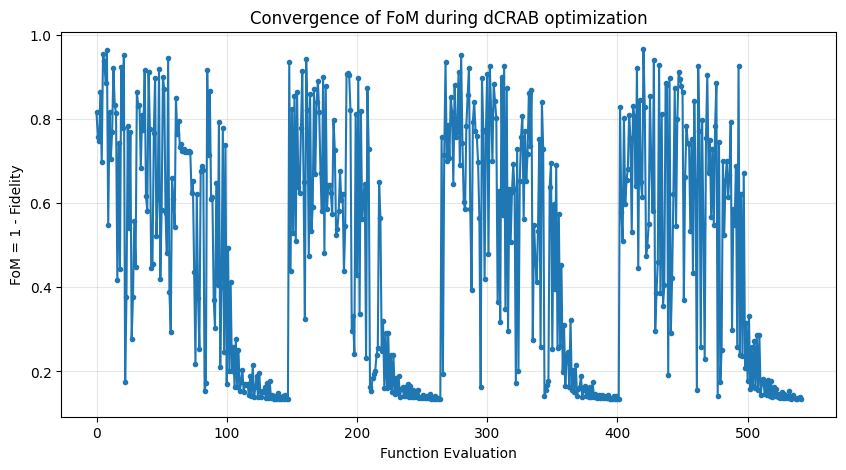

In [7]:
import numpy as np
import matplotlib.pyplot as plt


opt_alg = optimizer.get_optimization_algorithm()


fom_list = np.array(opt_alg.FoM_list)
N = len(fom_list)

plt.figure(figsize=(10,5))
plt.plot(fom_list, "-o", markersize=3)
plt.xlabel("Function Evaluation")
plt.ylabel("FoM = 1 - Fidelity")
plt.title("Convergence of FoM during dCRAB optimization")
plt.grid(alpha=0.3)
plt.show()


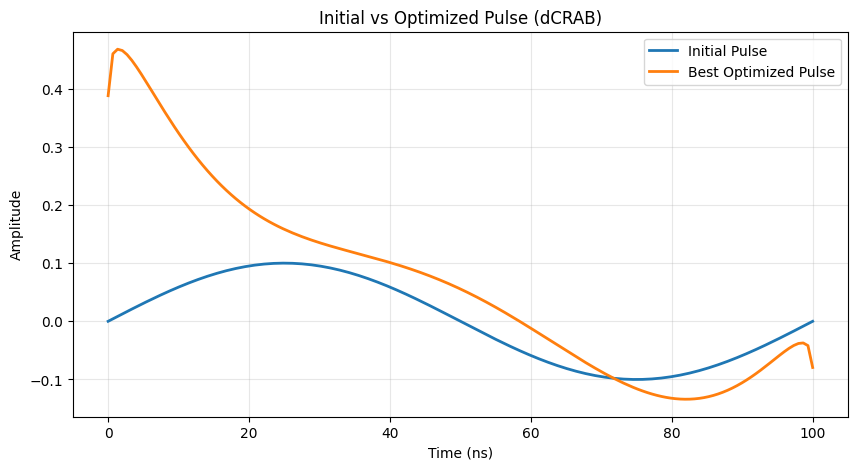

In [8]:
import numpy as np
import matplotlib.pyplot as plt


best_controls = opt_alg.get_best_controls()
best_pulse = np.array(best_controls["pulses"][0])
time_best = np.array(best_controls["timegrids"][0])


T = time_best[-1]
initial_pulse = 0.1 * np.sin(2 * np.pi * time_best / T)

# Plot comparison
plt.figure(figsize=(10,5))
plt.plot(time_best, initial_pulse, label="Initial Pulse", linewidth=2)
plt.plot(time_best, best_pulse, label="Best Optimized Pulse", linewidth=2)
plt.xlabel("Time (ns)")
plt.ylabel("Amplitude")
plt.title("Initial vs Optimized Pulse (dCRAB)")
plt.legend()
plt.grid(alpha=0.3)
plt.show()
